In [1]:
import torch
import torch.distributions as D
import torch.nn as nn
import numpy as np
import copy
from optimal_transport import OTPlanSampler

from IPython.display import display, HTML

from matplotlib import pyplot as plt
from matplotlib import animation
import scipy.optimize as opt
from scipy.stats import entropy
from numpy.linalg import norm
import seaborn as sns
import copy

/net/galaxy/home/koes/rishal/.conda/envs/torsional/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Initial and final distributions

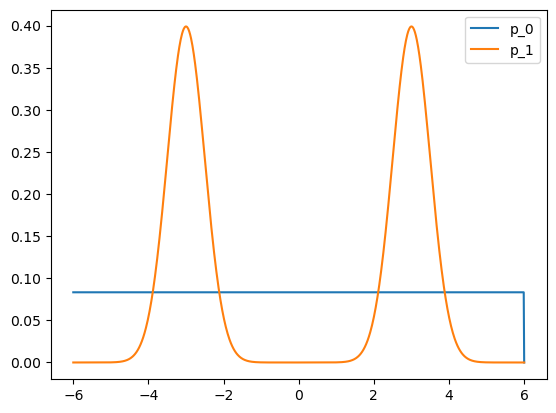

In [2]:
def build_gmm(n_modes, means=None, vars=None):

    if means is None:
        means = torch.randn(n_modes,1)
    if vars is None:
        vars = torch.rand(n_modes,1)
        vars[:,1] = vars[:,0]

    mix = D.Categorical(torch.ones(n_modes,))
    comp = D.Independent(D.Normal(means, vars), 1)
    gmm = D.MixtureSameFamily(mix, comp)
    return gmm


p_0_low = -6
p_0_high = 6
p_0 = D.Uniform(p_0_low, p_0_high)


p_1_means = torch.tensor([[3], [ -3]]).float()
p_1_vars = torch.ones(2,1)*0.5
p_1 = build_gmm(2, p_1_means, p_1_vars)

x=np.linspace(-6,6,1000)
plt.plot(x, p_0.log_prob(torch.tensor(x)).exp(), label='p_0')
plt.plot(x, p_1.log_prob(torch.tensor(x).unsqueeze(1)).exp(), label='p_1')
# plt.gca().set_aspect('equal', adjustable='box')
# xlim = plt.gca().get_xlim()
# ylim = plt.gca().get_ylim()
plt.legend()
plt.show()

## Train flow matching model

In [3]:
u = nn.Sequential(
        nn.Linear(2, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, 15),
        nn.ReLU(),
        nn.Linear(15, 1)
    )

In [11]:
def train_flow_matching_model(u,n_iterations, batch_size, p_0, p_1, learning_rate=1.0e-4, sigma=0.1, use_ot=False,model_weights=None):
    
    if model_weights is not None:
        u.load_state_dict(torch.load(model_weights))
    u=u.cuda()

    # intitalize adam optimizer
    optimizer = torch.optim.Adam(u.parameters(), lr=learning_rate)

    if use_ot:
        ot_sampler = OTPlanSampler()

    losses = []

    for iter_idx in range(n_iterations):

        # zero out gradients
        optimizer.zero_grad()

        x_0 = p_0.sample((batch_size,1))
        x_1 = p_1.sample((batch_size,))
        if use_ot:
            x_0, x_1 = ot_sampler.sample_plan(x_0, x_1)
        x_0 = x_0.cuda()
        x_1 = x_1.cuda()

        # sample time
        t = torch.rand(batch_size,).cuda()

        # construct x_t
        mu_x_t = x_0 + t[:,None]*(x_1 - x_0)
        # sigma_x_t = sigma*torch.ones_like(mu_x_t)
        # x_t = mu_x_t + sigma_x_t*torch.randn_like(mu_x_t)
        x_t  = mu_x_t

        # compute true conditional vectors
        u_true = x_1 - x_0

        # predict conditional vectors
        u_pred = u(torch.cat((x_t, t[:,None]), dim=-1))

        # compute loss
        loss = torch.square(u_true - u_pred).sum(dim=1).mean()

        # compute gradients
        loss.backward()

        # update parameters
        optimizer.step()


        losses.append(loss.item())
        if iter_idx % 100 == 0:
            print(f'Iteration {iter_idx}, loss = {loss.item():.2f}')
            #save model weights
            torch.save(u.state_dict(), 'model_weights_uniform.pth')
    
    return losses, u

losses, u = train_flow_matching_model(u=u,n_iterations=int(1000000), batch_size=64, p_0=p_0, p_1=p_1, learning_rate=1.0e-5, sigma=0.001, use_ot=True)

# print the average loss in the last 100 iterations
print(f'Final loss = {np.mean(losses[-100:]):.2f}')

plt.plot(losses)
plt.show()

Iteration 0, loss = 0.46


Iteration 100, loss = 0.32
Iteration 200, loss = 0.24
Iteration 300, loss = 1.05
Iteration 400, loss = 0.91
Iteration 500, loss = 0.35
Iteration 600, loss = 0.36
Iteration 700, loss = 0.95
Iteration 800, loss = 1.66
Iteration 900, loss = 0.24
Iteration 1000, loss = 0.53
Iteration 1100, loss = 0.69
Iteration 1200, loss = 0.19
Iteration 1300, loss = 1.72
Iteration 1400, loss = 2.06
Iteration 1500, loss = 0.28
Iteration 1600, loss = 3.35
Iteration 1700, loss = 0.20
Iteration 1800, loss = 0.28
Iteration 1900, loss = 0.26
Iteration 2000, loss = 2.01
Iteration 2100, loss = 0.39
Iteration 2200, loss = 0.30
Iteration 2300, loss = 1.20
Iteration 2400, loss = 0.43
Iteration 2500, loss = 0.52
Iteration 2600, loss = 0.79
Iteration 2700, loss = 0.30
Iteration 2800, loss = 0.29
Iteration 2900, loss = 0.26
Iteration 3000, loss = 0.15
Iteration 3100, loss = 0.50
Iteration 3200, loss = 0.97
Iteration 3300, loss = 0.19
Iteration 3400, loss = 0.25
Iteration 3500, loss = 0.51
Iteration 3600, loss = 0.96
I

KeyboardInterrupt: 

Integrate vector field

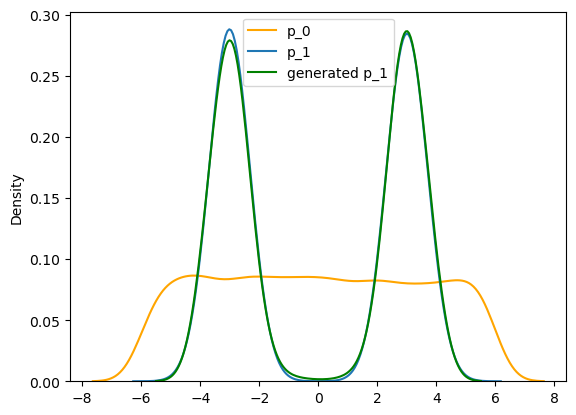

In [4]:
@torch.no_grad()
def integrate_u(x_0, u, n_steps=20):
    """Use Euler integration to integrate the time-varying vector field u from 0 to 1"""

    # x_0 is a tensor of shape (batch_size, 2) containing the initial positions
    # u is a time varying vector field (the trained neural network)
    # n_steps is the number of integration steps to run
    batch_size = x_0.shape[0]
    t = torch.linspace(0, 1, n_steps).cuda()
    dt = t[1] - t[0]
    x_t = torch.zeros(*x_0.shape, n_steps, dtype=x_0.dtype).cuda() # state, has shape (batch_size, 2, n_steps)
    x_t[:,:,0] = x_0
    for step_idx in range(n_steps-1):
        current_state = x_t[:, :, step_idx].cuda()
        u_input = torch.cat((current_state, t[step_idx]*torch.ones(batch_size, 1).cuda()), dim=-1)
        x_t[:, :, step_idx+1] = current_state + dt*u(u_input)
    return t, x_t

# def make_density_plot(dist, xlim, ylim, n_points=100, cmap='Reds', alpha=0.75):
#     # plot p_0 and p_1 densities on a mesh grid
#     x = torch.linspace(*xlim, n_points)
#     y = torch.linspace(*ylim, n_points)
#     X, Y = torch.meshgrid(x, y)
#     grid = torch.stack((X.flatten(), Y.flatten()), dim=-1)
#     density = torch.exp(dist.log_prob(grid)).reshape(n_points,n_points)
#     plt.pcolormesh(X, Y, density, cmap=cmap, alpha=alpha)


# make_density_plot(dist=p_0, xlim=xlim, ylim=ylim, cmap='Reds', alpha=0.5)
# make_density_plot(dist=p_1, xlim=xlim, ylim=ylim, cmap='Blues', alpha=0.5)
u.load_state_dict(torch.load('model_weights_uniform.pth'))
u=u.cuda()
n_trajectories = 10000
x_0 = p_0.sample((n_trajectories,1)).cuda()
t, x_t = integrate_u(x_0, u, n_steps=20)
t=t.detach().cpu().numpy()
x_t=x_t.detach().cpu().numpy()

# for traj_idx in range(n_trajectories):
#     plt.plot(x_t[traj_idx,0,:], x_t[traj_idx,1,:], alpha=0.2 , lw=3, color='gray')

    
# plt.gca().set_aspect('equal', )
samples_0 = p_0.sample((10000,1))



samples_1 = p_1.sample((10000,))
sns.kdeplot(samples_0[:, 0], label='p_0',color='orange')
sns.kdeplot(samples_1, label='p_1',color='red')
sns.kdeplot(x_t[:,0,-1], label='generated p_1',color='green')
# plt.gca().set_aspect('equal', adjustable='box')
# xlim = plt.gca().get_xlim()
# ylim = plt.gca().get_ylim()
plt.legend()
plt.show()


## NCE across the 20 timepoints

In [5]:
#nce value function

def value(energy, noise, x, gen,exponential=False):
    logp_x = energy(x)  # logp(x)
    try:
        logq_x = noise.log_prob(x).cuda()  # logq(x)
    except:
        logq_x = noise.log_prob(x.clone().detach().cpu()).cuda()
    logp_gen = energy(gen)  # logp(x̃)
    try:
        logq_gen = noise.log_prob(gen).cuda()  # logq(x̃)
    except:
        logq_gen = noise.log_prob(gen.clone().detach().cpu()).cuda()
    if not exponential:    
        value_data = logp_x - torch.logsumexp(torch.cat([logp_x, logq_x], dim=1), dim=1, keepdim=True)  # log[p(x)/(p(x) + q(x))]
        value_gen = logq_gen - torch.logsumexp(torch.cat([logp_gen, logq_gen], dim=1), dim=1, keepdim=True)  # log[q(x̃)/(p(x̃) + q(x̃))]
    else:
        value_data = -torch.exp(-(0.5*logp_x - 0.5*logq_x))
        value_gen = -torch.exp(0.5*logp_gen - 0.5*logq_gen)

    v = value_data.mean() + value_gen.mean()

    r_x = torch.sigmoid(logp_x - logq_x)
    r_gen = torch.sigmoid(logq_gen - logp_gen)

    acc = ((r_x > 1/2).sum() + (r_gen > 1/2).sum()).cpu().numpy() / (len(x) + len(gen))

    return -v,  acc

In [6]:
#define neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1=nn.Linear(1, 100)
        self.fc2=nn.Linear(100, 100)
        self.fc3=nn.Linear(100, 1)
        self.partition=nn.Parameter(torch.tensor([1.], requires_grad=True))
    
    def forward(self, x):
        x=torch.relu(self.fc1(x))
        x=torch.relu(self.fc2(x))
        x=self.fc3(x)
        return - x - torch.log(self.partition)
    
    def log_prob(self, x):
        return self.forward(x)

In [7]:
def bar_function(x,diff_1,diff_2):
    term_1=np.sum(1/(1+np.exp(diff_1 - x)))
    term_2=np.sum(1/(1+np.exp(diff_2 + x)))
    return (term_1-term_2)**2

In [8]:
def kl_divergence(prev_probs,current_probs):
    log_ratio=torch.log(prev_probs/(current_probs + 1e-10))
    return torch.sum(prev_probs*log_ratio)
    

In [9]:
def jensen_shanon_div(P,Q):
    P=P.cpu().numpy()
    Q=Q.cpu().numpy()
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return np.abs(0.5 * (entropy(_P, _M) + entropy(_Q, _M)))

In [10]:
u.load_state_dict(torch.load('model_weights_uniform.pth'))
u=u.cuda()

In [11]:

def train(u,training_iterations,lr=1e-4,bar=False,exponential=False,normalize_grad=False):
    prev_dist=p_0
    for T in range(20):
        model=Net().cuda()
        if T!=0:
            prev_dist=prev_dist.eval()
        optimizer=torch.optim.Adam(model.parameters(), lr=lr)
        training_iterations=training_iterations
        batch_size=10000
        prev_probs=(1/10000 * torch.ones((batch_size,1))).cuda()
        min_js=10
        counter=1
        for i in range(training_iterations):
            optimizer.zero_grad()
            x_0 = p_0.sample((batch_size,1)).cuda()
            t, x_t = integrate_u(x_0, u, n_steps=20)
            if T!=19:
                x_batch=x_t[:,:,T+1].cuda()
            else:
                x_batch=p_1.sample((batch_size,)).cuda()
            loss, acc=value(model, prev_dist, x_batch, x_t[:,:,T].cuda(),exponential=exponential)
            loss.backward()
            if normalize_grad:
                for param in model.parameters():
                    if param.grad is not None:
                        param.grad /= (torch.norm(param.grad, p=2) + 1e-6)
            nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            if i%100==0:
                with torch.no_grad():
                    if i!=0:
                        prev_probs=torch.exp(prev_model(x_batch))
                    current_probs=torch.exp(model(x_batch))
                    kl_div=kl_divergence(prev_probs,current_probs)
                    js_div=jensen_shanon_div(prev_probs,current_probs)
                    if js_div<min_js:
                        min_js=js_div
                        counter=1
                    else:
                        counter+=1
                    mse=torch.mean((current_probs-prev_probs)**2)
                    prev_model=copy.deepcopy(model)
                    print('Time: ', T,'iteration: ', i,'loss: ', loss.item(), 'acc: ', acc, 'kl_div: ',kl_div,'mse: ',mse,'js_div: ',js_div)
            if counter>=20:
                optimizer.param_groups[0]['lr']=optimizer.param_groups[0]['lr']/10
                counter=1
                if optimizer.param_groups[0]['lr']<1e-6:
                    break
        if bar:
            if T!=0:
                x_t_prev_energy=(prev_dist.log_prob(x_t[:,:,T].cuda())+torch.log(prev_dist.partition)).detach().cpu().numpy()
            else:
                x_t_prev_energy=prev_dist.log_prob(x_t[:,:,T].clone().detach().cpu()).numpy()
            x_t_curr_energy=(model(x_t[:,:,T])+torch.log(model.partition)).detach().cpu().numpy()
            diff_1=-x_t_prev_energy+x_t_curr_energy
            if T!=0:
                x_batch_prev_energy=(prev_dist.log_prob(x_batch)+torch.log(prev_dist.partition)).detach().cpu().numpy()
            else:
                x_batch_prev_energy=prev_dist.log_prob(x_batch.clone().detach().cpu()).numpy()
            x_batch_curr_energy=(model(x_batch)+torch.log(model.partition)).detach().cpu().numpy()
            diff_2 = x_batch_prev_energy-x_batch_curr_energy
            if T!=0:
                initial_guess=prev_dist.partition.clone().detach().cpu().numpy() - model.partition.clone().detach().cpu().numpy()
            else:
                initial_guess=model.partition.clone().detach().cpu().numpy()
            free_energy=opt.basinhopping(bar_function,initial_guess,minimizer_kwargs={"args": (diff_1,diff_2,)},niter=1000)
            if T!=0:
                model.partition = nn.Parameter(torch.tensor([torch.exp(torch.log(prev_dist.partition) + torch.tensor([free_energy.x]).cuda())], requires_grad=True,device="cuda"))
            else:
                model.partition = nn.Parameter(torch.tensor([torch.exp(torch.tensor([free_energy.x]))], requires_grad=True,device="cuda"))
        model.cuda()
        x=np.linspace(-6, 6, 1000)
        x=torch.Tensor(x).cuda().unsqueeze(1)
        initial_energy=p_0.log_prob(x.detach().cpu()).squeeze().numpy()
        true_energy=p_1.log_prob(x.detach().cpu()).squeeze().numpy()
        energy=model(x).detach().cpu().squeeze().numpy()
        x=x.cpu().squeeze().numpy()
        plt.plot(x, np.exp(initial_energy), label='p0')
        plt.plot(x, np.exp(true_energy), label='p1')
        plt.plot(x, np.exp(energy),label='model_p1_'+str(T+1))
        plt.legend()
        plt.show()
        prev_dist=copy.deepcopy(model)
        print('T: ', T)
    return model
    
        

Time:  0 iteration:  0 loss:  2.574718952178955 acc:  0.5 kl_div:  tensor(-9.1032, device='cuda:0') mse:  tensor(0.8165, device='cuda:0') js_div:  [0.00073506]
Time:  0 iteration:  100 loss:  1.6012797355651855 acc:  0.50305 kl_div:  tensor(16982.0469, device='cuda:0') mse:  tensor(0.5234, device='cuda:0') js_div:  [0.06147644]
Time:  0 iteration:  200 loss:  1.4883489608764648 acc:  0.50315 kl_div:  tensor(675.0326, device='cuda:0') mse:  tensor(0.0079, device='cuda:0') js_div:  [0.00715685]
Time:  0 iteration:  300 loss:  1.4073330163955688 acc:  0.50365 kl_div:  tensor(410.3705, device='cuda:0') mse:  tensor(0.0030, device='cuda:0') js_div:  [0.0104327]
Time:  0 iteration:  400 loss:  1.3866198062896729 acc:  0.50475 kl_div:  tensor(140.9212, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00473866]
Time:  0 iteration:  500 loss:  1.385191559791565 acc:  0.5095 kl_div:  tensor(26.5291, device='cuda:0') mse:  tensor(2.8422e-05, device='cuda:0') js_div:  [0.0003743]

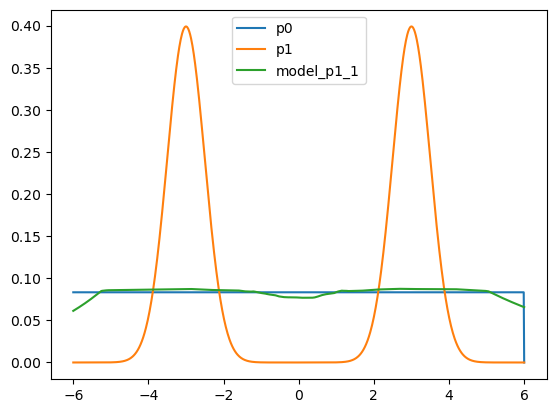

T:  0
Time:  1 iteration:  0 loss:  2.815582513809204 acc:  0.5 kl_div:  tensor(-9.3827, device='cuda:0') mse:  tensor(1.5022, device='cuda:0') js_div:  [0.00386337]
Time:  1 iteration:  100 loss:  1.6063683032989502 acc:  0.5034 kl_div:  tensor(29079.7461, device='cuda:0') mse:  tensor(1.1827, device='cuda:0') js_div:  [0.10838315]
Time:  1 iteration:  200 loss:  1.4893550872802734 acc:  0.5028 kl_div:  tensor(696.1869, device='cuda:0') mse:  tensor(0.0087, device='cuda:0') js_div:  [0.00804335]
Time:  1 iteration:  300 loss:  1.4124186038970947 acc:  0.5032 kl_div:  tensor(396.8454, device='cuda:0') mse:  tensor(0.0029, device='cuda:0') js_div:  [0.00920717]
Time:  1 iteration:  400 loss:  1.3900936841964722 acc:  0.5006 kl_div:  tensor(151.3071, device='cuda:0') mse:  tensor(0.0006, device='cuda:0') js_div:  [0.00461856]
Time:  1 iteration:  500 loss:  1.3874096870422363 acc:  0.49965 kl_div:  tensor(31.6417, device='cuda:0') mse:  tensor(4.6303e-05, device='cuda:0') js_div:  [0.000

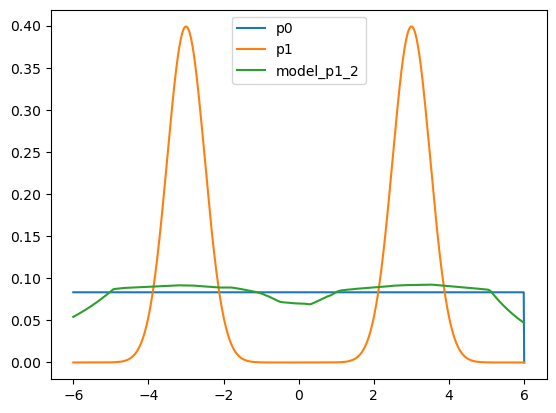

T:  1
Time:  2 iteration:  0 loss:  2.567765712738037 acc:  0.5 kl_div:  tensor(-9.1023, device='cuda:0') mse:  tensor(0.8251, device='cuda:0') js_div:  [0.00154441]
Time:  2 iteration:  100 loss:  1.5817320346832275 acc:  0.5028 kl_div:  tensor(17547.6562, device='cuda:0') mse:  tensor(0.5507, device='cuda:0') js_div:  [0.05918927]
Time:  2 iteration:  200 loss:  1.4740080833435059 acc:  0.50265 kl_div:  tensor(563.8331, device='cuda:0') mse:  tensor(0.0060, device='cuda:0') js_div:  [0.00777858]
Time:  2 iteration:  300 loss:  1.4085856676101685 acc:  0.4978 kl_div:  tensor(344.0666, device='cuda:0') mse:  tensor(0.0023, device='cuda:0') js_div:  [0.00903166]
Time:  2 iteration:  400 loss:  1.3914697170257568 acc:  0.4913 kl_div:  tensor(111.8308, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.0036067]
Time:  2 iteration:  500 loss:  1.3888320922851562 acc:  0.49335 kl_div:  tensor(19.8752, device='cuda:0') mse:  tensor(3.3327e-05, device='cuda:0') js_div:  [0.000

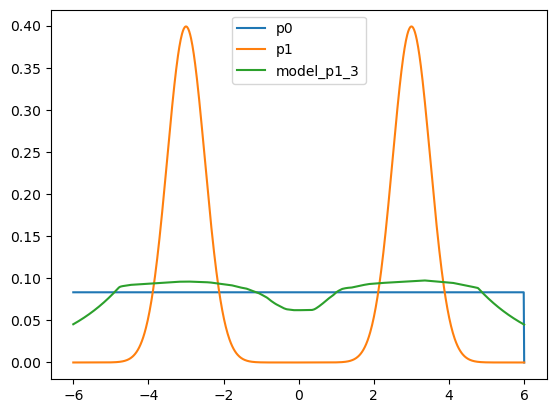

T:  2
Time:  3 iteration:  0 loss:  2.3535959720611572 acc:  0.5 kl_div:  tensor(-8.8302, device='cuda:0') mse:  tensor(0.5613, device='cuda:0') js_div:  [0.01197436]
Time:  3 iteration:  100 loss:  1.5521833896636963 acc:  0.50245 kl_div:  tensor(12589.8477, device='cuda:0') mse:  tensor(0.3543, device='cuda:0') js_div:  [0.04514201]
Time:  3 iteration:  200 loss:  1.4505144357681274 acc:  0.501 kl_div:  tensor(520.6092, device='cuda:0') mse:  tensor(0.0051, device='cuda:0') js_div:  [0.01002475]
Time:  3 iteration:  300 loss:  1.404296636581421 acc:  0.49375 kl_div:  tensor(236.7532, device='cuda:0') mse:  tensor(0.0013, device='cuda:0') js_div:  [0.00723716]
Time:  3 iteration:  400 loss:  1.392287015914917 acc:  0.4887 kl_div:  tensor(66.9123, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00207823]
Time:  3 iteration:  500 loss:  1.3892316818237305 acc:  0.49545 kl_div:  tensor(13.3161, device='cuda:0') mse:  tensor(3.0376e-05, device='cuda:0') js_div:  [0.0004

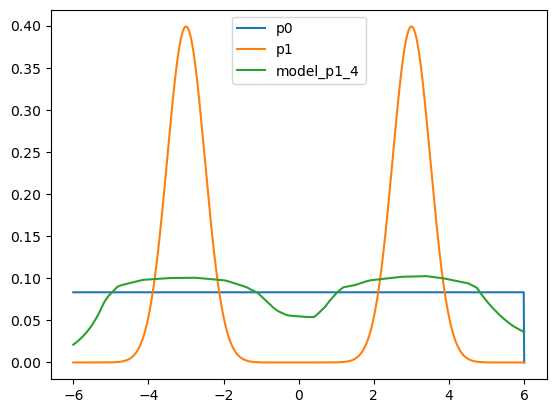

T:  3
Time:  4 iteration:  0 loss:  2.380162477493286 acc:  0.5 kl_div:  tensor(-8.8929, device='cuda:0') mse:  tensor(0.5508, device='cuda:0') js_div:  [0.0024343]
Time:  4 iteration:  100 loss:  1.5565654039382935 acc:  0.5019 kl_div:  tensor(12559.1504, device='cuda:0') mse:  tensor(0.3358, device='cuda:0') js_div:  [0.03867036]
Time:  4 iteration:  200 loss:  1.469059705734253 acc:  0.4983 kl_div:  tensor(504.6649, device='cuda:0') mse:  tensor(0.0049, device='cuda:0') js_div:  [0.00736208]
Time:  4 iteration:  300 loss:  1.411391019821167 acc:  0.4912 kl_div:  tensor(275.4359, device='cuda:0') mse:  tensor(0.0017, device='cuda:0') js_div:  [0.00854209]
Time:  4 iteration:  400 loss:  1.3962814807891846 acc:  0.49365 kl_div:  tensor(82.3396, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00302268]
Time:  4 iteration:  500 loss:  1.392646074295044 acc:  0.492 kl_div:  tensor(15.8131, device='cuda:0') mse:  tensor(2.8778e-05, device='cuda:0') js_div:  [0.00045133]

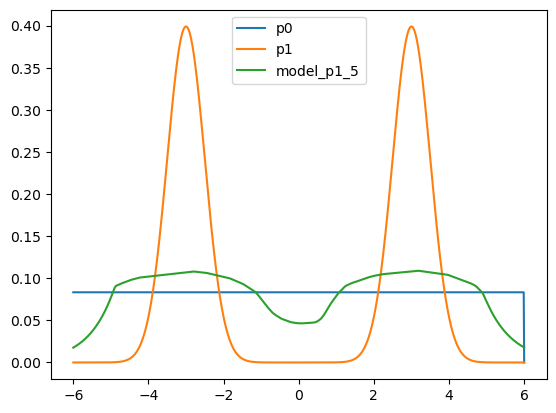

T:  4
Time:  5 iteration:  0 loss:  2.7600021362304688 acc:  0.5 kl_div:  tensor(-9.3766, device='cuda:0') mse:  tensor(1.3993, device='cuda:0') js_div:  [0.00022203]
Time:  5 iteration:  100 loss:  1.6035512685775757 acc:  0.50155 kl_div:  tensor(26435.6367, device='cuda:0') mse:  tensor(1.0383, device='cuda:0') js_div:  [0.07140107]
Time:  5 iteration:  200 loss:  1.504852294921875 acc:  0.49295 kl_div:  tensor(477.9257, device='cuda:0') mse:  tensor(0.0056, device='cuda:0') js_div:  [0.00754261]
Time:  5 iteration:  300 loss:  1.441028356552124 acc:  0.49065 kl_div:  tensor(343.8159, device='cuda:0') mse:  tensor(0.0025, device='cuda:0') js_div:  [0.00760997]
Time:  5 iteration:  400 loss:  1.4124393463134766 acc:  0.48735 kl_div:  tensor(143.0733, device='cuda:0') mse:  tensor(0.0006, device='cuda:0') js_div:  [0.00453593]
Time:  5 iteration:  500 loss:  1.4038174152374268 acc:  0.4837 kl_div:  tensor(37.7189, device='cuda:0') mse:  tensor(8.7579e-05, device='cuda:0') js_div:  [0.0

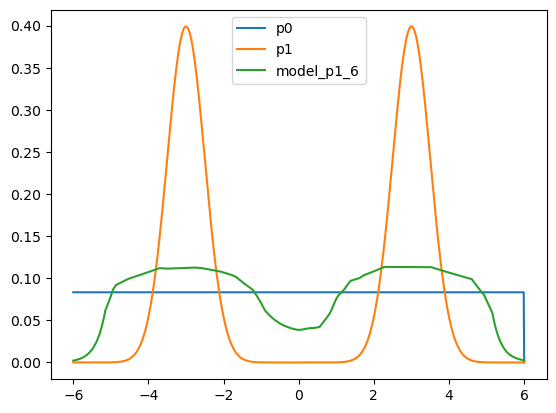

T:  5
Time:  6 iteration:  0 loss:  2.5955216884613037 acc:  0.5 kl_div:  tensor(-9.2068, device='cuda:0') mse:  tensor(1.0563, device='cuda:0') js_div:  [0.00387417]
Time:  6 iteration:  100 loss:  1.5837104320526123 acc:  0.49375 kl_div:  tensor(21818.4727, device='cuda:0') mse:  tensor(0.7850, device='cuda:0') js_div:  [0.06705141]
Time:  6 iteration:  200 loss:  1.5111277103424072 acc:  0.4909 kl_div:  tensor(294.1682, device='cuda:0') mse:  tensor(0.0028, device='cuda:0') js_div:  [0.00488418]
Time:  6 iteration:  300 loss:  1.4580199718475342 acc:  0.49065 kl_div:  tensor(269.7245, device='cuda:0') mse:  tensor(0.0018, device='cuda:0') js_div:  [0.00514517]
Time:  6 iteration:  400 loss:  1.424342393875122 acc:  0.4884 kl_div:  tensor(147.0652, device='cuda:0') mse:  tensor(0.0007, device='cuda:0') js_div:  [0.00437887]
Time:  6 iteration:  500 loss:  1.4131455421447754 acc:  0.4832 kl_div:  tensor(55.9162, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.001626

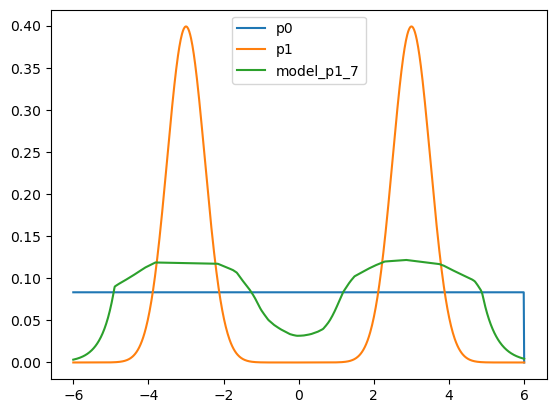

T:  6
Time:  7 iteration:  0 loss:  2.43070387840271 acc:  0.5 kl_div:  tensor(-9.0421, device='cuda:0') mse:  tensor(0.7736, device='cuda:0') js_div:  [0.00516434]
Time:  7 iteration:  100 loss:  1.5624215602874756 acc:  0.49145 kl_div:  tensor(16173.3711, device='cuda:0') mse:  tensor(0.5257, device='cuda:0') js_div:  [0.03908852]
Time:  7 iteration:  200 loss:  1.4820822477340698 acc:  0.4892 kl_div:  tensor(409.0456, device='cuda:0') mse:  tensor(0.0037, device='cuda:0') js_div:  [0.0072308]
Time:  7 iteration:  300 loss:  1.4322065114974976 acc:  0.4864 kl_div:  tensor(225.4352, device='cuda:0') mse:  tensor(0.0014, device='cuda:0') js_div:  [0.00711386]
Time:  7 iteration:  400 loss:  1.4145894050598145 acc:  0.48165 kl_div:  tensor(71.6685, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00271679]
Time:  7 iteration:  500 loss:  1.4075567722320557 acc:  0.48475 kl_div:  tensor(13.5968, device='cuda:0') mse:  tensor(4.2323e-05, device='cuda:0') js_div:  [0.0006

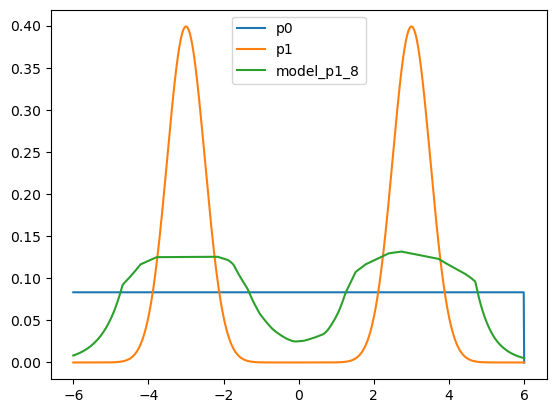

T:  7
Time:  8 iteration:  0 loss:  2.538841962814331 acc:  0.5 kl_div:  tensor(-9.2278, device='cuda:0') mse:  tensor(1.0619, device='cuda:0') js_div:  [0.00156932]
Time:  8 iteration:  100 loss:  1.5767730474472046 acc:  0.4971 kl_div:  tensor(21387.7969, device='cuda:0') mse:  tensor(0.7743, device='cuda:0') js_div:  [0.06236231]
Time:  8 iteration:  200 loss:  1.5142487287521362 acc:  0.49065 kl_div:  tensor(256.8485, device='cuda:0') mse:  tensor(0.0022, device='cuda:0') js_div:  [0.00420894]
Time:  8 iteration:  300 loss:  1.4692308902740479 acc:  0.48865 kl_div:  tensor(234.5878, device='cuda:0') mse:  tensor(0.0014, device='cuda:0') js_div:  [0.00398266]
Time:  8 iteration:  400 loss:  1.44339919090271 acc:  0.48265 kl_div:  tensor(136.7097, device='cuda:0') mse:  tensor(0.0007, device='cuda:0') js_div:  [0.00349135]
Time:  8 iteration:  500 loss:  1.4253263473510742 acc:  0.4805 kl_div:  tensor(58.2827, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.0016902

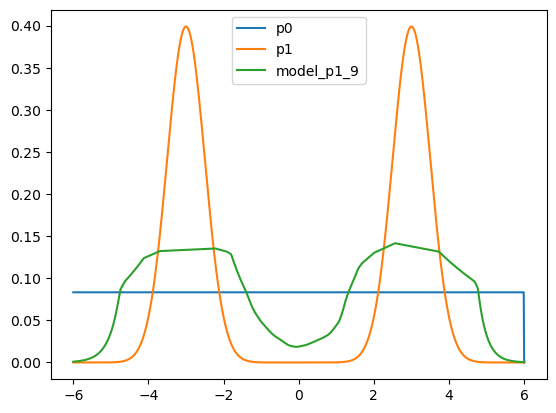

T:  8
Time:  9 iteration:  0 loss:  2.2639150619506836 acc:  0.5 kl_div:  tensor(-8.8969, device='cuda:0') mse:  tensor(0.6455, device='cuda:0') js_div:  [0.0123205]
Time:  9 iteration:  100 loss:  1.583747148513794 acc:  0.4901 kl_div:  tensor(12527.0361, device='cuda:0') mse:  tensor(0.3900, device='cuda:0') js_div:  [0.0394916]
Time:  9 iteration:  200 loss:  1.5376708507537842 acc:  0.4894 kl_div:  tensor(317.8705, device='cuda:0') mse:  tensor(0.0028, device='cuda:0') js_div:  [0.00316548]
Time:  9 iteration:  300 loss:  1.481304407119751 acc:  0.48675 kl_div:  tensor(266.4956, device='cuda:0') mse:  tensor(0.0020, device='cuda:0') js_div:  [0.00479612]
Time:  9 iteration:  400 loss:  1.4517122507095337 acc:  0.4814 kl_div:  tensor(161.9031, device='cuda:0') mse:  tensor(0.0009, device='cuda:0') js_div:  [0.00445818]
Time:  9 iteration:  500 loss:  1.430876612663269 acc:  0.4829 kl_div:  tensor(52.2392, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00186651]
T

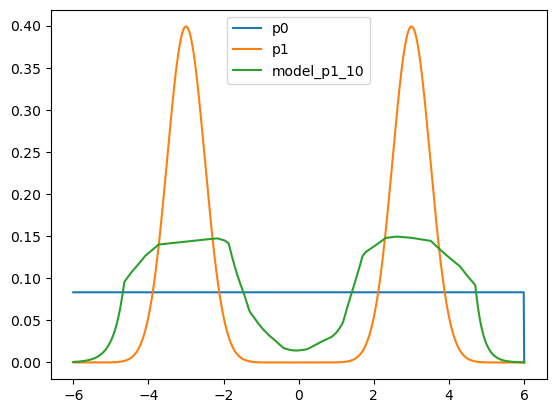

T:  9
Time:  10 iteration:  0 loss:  2.397988796234131 acc:  0.5 kl_div:  tensor(-9.1342, device='cuda:0') mse:  tensor(0.9521, device='cuda:0') js_div:  [0.0065793]
Time:  10 iteration:  100 loss:  1.5544490814208984 acc:  0.49155 kl_div:  tensor(17583.8398, device='cuda:0') mse:  tensor(0.6501, device='cuda:0') js_div:  [0.03561659]
Time:  10 iteration:  200 loss:  1.5075953006744385 acc:  0.4853 kl_div:  tensor(344.0567, device='cuda:0') mse:  tensor(0.0027, device='cuda:0') js_div:  [0.00395995]
Time:  10 iteration:  300 loss:  1.4730732440948486 acc:  0.482 kl_div:  tensor(170.5302, device='cuda:0') mse:  tensor(0.0010, device='cuda:0') js_div:  [0.00337307]
Time:  10 iteration:  400 loss:  1.4480514526367188 acc:  0.47705 kl_div:  tensor(88.9016, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.0024981]
Time:  10 iteration:  500 loss:  1.4321178197860718 acc:  0.48 kl_div:  tensor(36.4061, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.001302

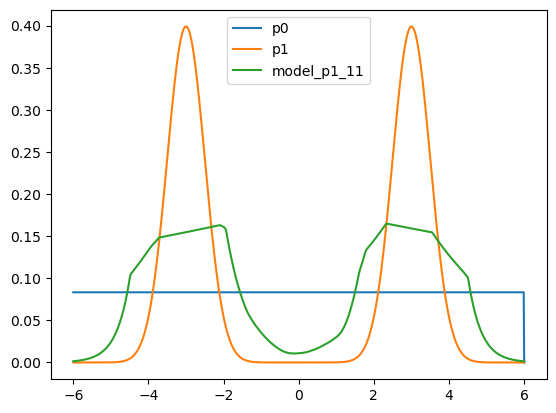

T:  10
Time:  11 iteration:  0 loss:  2.1965556144714355 acc:  0.5 kl_div:  tensor(-8.9244, device='cuda:0') mse:  tensor(0.6847, device='cuda:0') js_div:  [0.01249104]
Time:  11 iteration:  100 loss:  1.5440534353256226 acc:  0.4866 kl_div:  tensor(13793.3750, device='cuda:0') mse:  tensor(0.4599, device='cuda:0') js_div:  [0.03648634]
Time:  11 iteration:  200 loss:  1.504108190536499 acc:  0.4853 kl_div:  tensor(184.3583, device='cuda:0') mse:  tensor(0.0015, device='cuda:0') js_div:  [0.0036085]
Time:  11 iteration:  300 loss:  1.4744657278060913 acc:  0.47895 kl_div:  tensor(150.6290, device='cuda:0') mse:  tensor(0.0009, device='cuda:0') js_div:  [0.00307821]
Time:  11 iteration:  400 loss:  1.4487203359603882 acc:  0.4773 kl_div:  tensor(72.7809, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.00205078]
Time:  11 iteration:  500 loss:  1.432235836982727 acc:  0.4785 kl_div:  tensor(29.1709, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.001

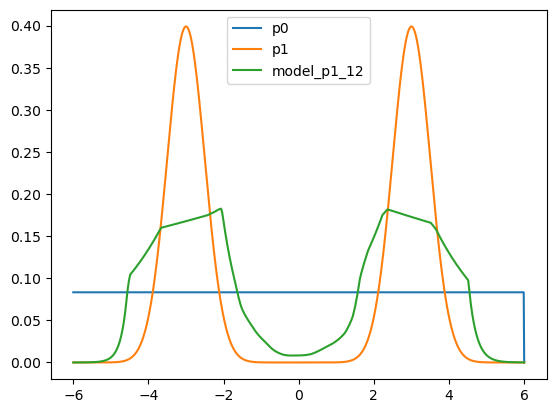

T:  11
Time:  12 iteration:  0 loss:  2.404139518737793 acc:  0.5 kl_div:  tensor(-9.2790, device='cuda:0') mse:  tensor(1.2408, device='cuda:0') js_div:  [0.00494877]
Time:  12 iteration:  100 loss:  1.5625003576278687 acc:  0.4876 kl_div:  tensor(20994.1641, device='cuda:0') mse:  tensor(0.8772, device='cuda:0') js_div:  [0.03414765]
Time:  12 iteration:  200 loss:  1.5315717458724976 acc:  0.48545 kl_div:  tensor(161.1133, device='cuda:0') mse:  tensor(0.0010, device='cuda:0') js_div:  [0.00141547]
Time:  12 iteration:  300 loss:  1.507406234741211 acc:  0.4823 kl_div:  tensor(131.6724, device='cuda:0') mse:  tensor(0.0007, device='cuda:0') js_div:  [0.00143133]
Time:  12 iteration:  400 loss:  1.4815348386764526 acc:  0.4762 kl_div:  tensor(107.4482, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.0017229]
Time:  12 iteration:  500 loss:  1.4667465686798096 acc:  0.47485 kl_div:  tensor(67.9753, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.0

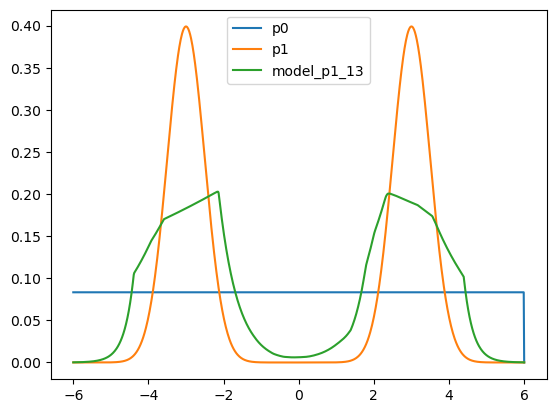

T:  12
Time:  13 iteration:  0 loss:  2.180011749267578 acc:  0.5 kl_div:  tensor(-9.0503, device='cuda:0') mse:  tensor(0.7344, device='cuda:0') js_div:  [0.00073225]
Time:  13 iteration:  100 loss:  1.53230619430542 acc:  0.4844 kl_div:  tensor(13680.9541, device='cuda:0') mse:  tensor(0.4537, device='cuda:0') js_div:  [0.01290431]
Time:  13 iteration:  200 loss:  1.5038485527038574 acc:  0.47625 kl_div:  tensor(197.3534, device='cuda:0') mse:  tensor(0.0013, device='cuda:0') js_div:  [0.00218436]
Time:  13 iteration:  300 loss:  1.476566195487976 acc:  0.4743 kl_div:  tensor(115.0463, device='cuda:0') mse:  tensor(0.0007, device='cuda:0') js_div:  [0.00249749]
Time:  13 iteration:  400 loss:  1.4578959941864014 acc:  0.4769 kl_div:  tensor(58.4498, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.0016766]
Time:  13 iteration:  500 loss:  1.4342148303985596 acc:  0.4776 kl_div:  tensor(13.2547, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00090

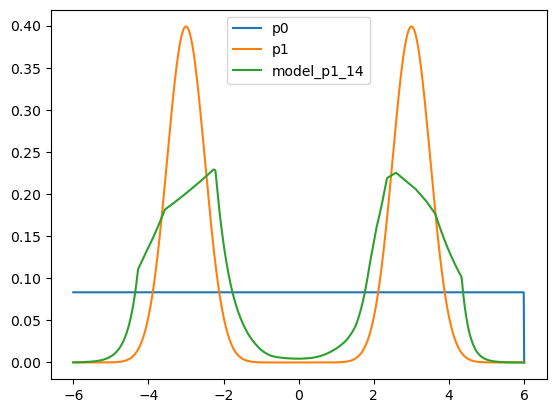

T:  13
Time:  14 iteration:  0 loss:  2.2117161750793457 acc:  0.5 kl_div:  tensor(-9.1656, device='cuda:0') mse:  tensor(0.9161, device='cuda:0') js_div:  [0.00013241]
Time:  14 iteration:  100 loss:  1.5367493629455566 acc:  0.4786 kl_div:  tensor(16017.3760, device='cuda:0') mse:  tensor(0.5914, device='cuda:0') js_div:  [0.01593267]
Time:  14 iteration:  200 loss:  1.5208377838134766 acc:  0.47365 kl_div:  tensor(98.1712, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00085293]
Time:  14 iteration:  300 loss:  1.5028682947158813 acc:  0.4721 kl_div:  tensor(101.4975, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00118449]
Time:  14 iteration:  400 loss:  1.4854415655136108 acc:  0.47335 kl_div:  tensor(77.7256, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.00126728]
Time:  14 iteration:  500 loss:  1.4650874137878418 acc:  0.477 kl_div:  tensor(50.1877, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.0

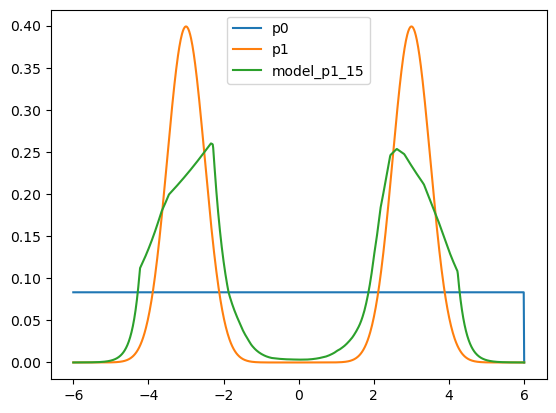

T:  14
Time:  15 iteration:  0 loss:  2.2994675636291504 acc:  0.5 kl_div:  tensor(-9.3639, device='cuda:0') mse:  tensor(1.3655, device='cuda:0') js_div:  [0.0002888]
Time:  15 iteration:  100 loss:  1.5564483404159546 acc:  0.47345 kl_div:  tensor(21035.3633, device='cuda:0') mse:  tensor(0.9284, device='cuda:0') js_div:  [0.01865058]
Time:  15 iteration:  200 loss:  1.5396361351013184 acc:  0.4744 kl_div:  tensor(30.8676, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00054466]
Time:  15 iteration:  300 loss:  1.5211100578308105 acc:  0.47245 kl_div:  tensor(84.8848, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.0005153]
Time:  15 iteration:  400 loss:  1.5166563987731934 acc:  0.473 kl_div:  tensor(82.4871, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.00070758]
Time:  15 iteration:  500 loss:  1.4954725503921509 acc:  0.47155 kl_div:  tensor(62.9715, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.000

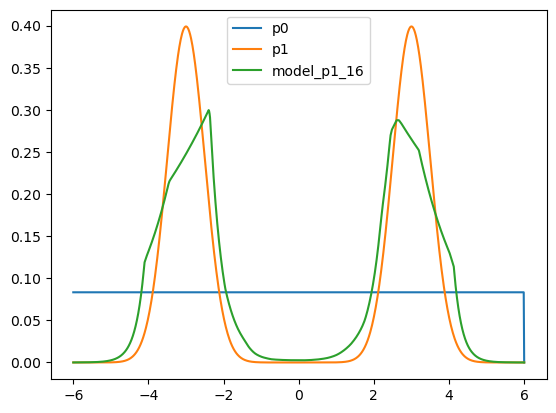

T:  15
Time:  16 iteration:  0 loss:  1.9058324098587036 acc:  0.5 kl_div:  tensor(-8.8576, device='cuda:0') mse:  tensor(0.5050, device='cuda:0') js_div:  [0.0014214]
Time:  16 iteration:  100 loss:  1.5354753732681274 acc:  0.4709 kl_div:  tensor(8739.4424, device='cuda:0') mse:  tensor(0.2501, device='cuda:0') js_div:  [0.00679049]
Time:  16 iteration:  200 loss:  1.5161590576171875 acc:  0.4727 kl_div:  tensor(19.9376, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00033716]
Time:  16 iteration:  300 loss:  1.509413719177246 acc:  0.47125 kl_div:  tensor(51.4785, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00037425]
Time:  16 iteration:  400 loss:  1.4968979358673096 acc:  0.4724 kl_div:  tensor(39.3041, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00043369]
Time:  16 iteration:  500 loss:  1.48525071144104 acc:  0.47125 kl_div:  tensor(31.3696, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.000519

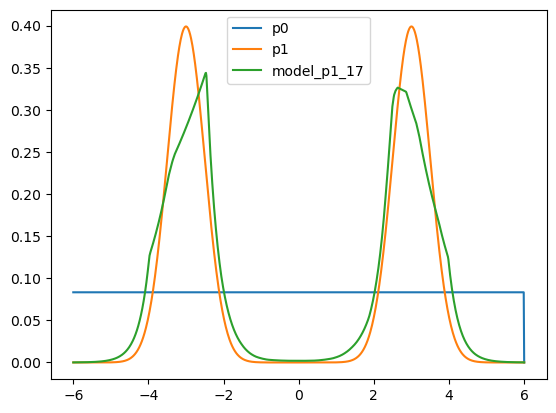

T:  16
Time:  17 iteration:  0 loss:  2.21152400970459 acc:  0.5 kl_div:  tensor(-9.4422, device='cuda:0') mse:  tensor(1.5994, device='cuda:0') js_div:  [0.00037935]
Time:  17 iteration:  100 loss:  1.5374650955200195 acc:  0.47085 kl_div:  tensor(22328.1562, device='cuda:0') mse:  tensor(1.0904, device='cuda:0') js_div:  [0.01163163]
Time:  17 iteration:  200 loss:  1.5373611450195312 acc:  0.4702 kl_div:  tensor(-47.0741, device='cuda:0') mse:  tensor(6.7241e-05, device='cuda:0') js_div:  [0.00010245]
Time:  17 iteration:  300 loss:  1.5371875762939453 acc:  0.46835 kl_div:  tensor(25.6806, device='cuda:0') mse:  tensor(6.6593e-05, device='cuda:0') js_div:  [9.3128576e-05]
Time:  17 iteration:  400 loss:  1.525346279144287 acc:  0.4702 kl_div:  tensor(31.8101, device='cuda:0') mse:  tensor(8.1527e-05, device='cuda:0') js_div:  [0.00012373]
Time:  17 iteration:  500 loss:  1.5264549255371094 acc:  0.4696 kl_div:  tensor(35.2897, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') 

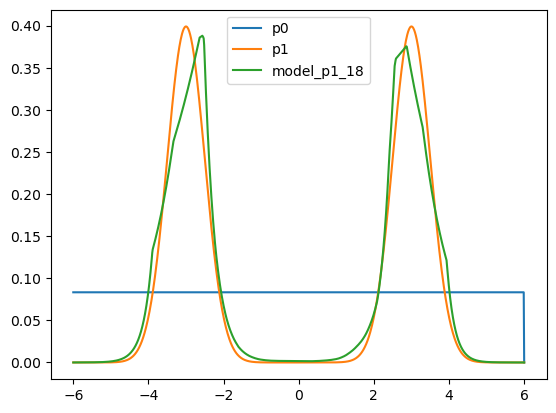

T:  17
Time:  18 iteration:  0 loss:  2.0764288902282715 acc:  0.5 kl_div:  tensor(-9.3345, device='cuda:0') mse:  tensor(1.2840, device='cuda:0') js_div:  [0.00011751]
Time:  18 iteration:  100 loss:  1.5473122596740723 acc:  0.4684 kl_div:  tensor(17431.0312, device='cuda:0') mse:  tensor(0.7870, device='cuda:0') js_div:  [0.00620253]
Time:  18 iteration:  200 loss:  1.5502545833587646 acc:  0.46985 kl_div:  tensor(-10.7765, device='cuda:0') mse:  tensor(5.4677e-05, device='cuda:0') js_div:  [8.8408065e-05]
Time:  18 iteration:  300 loss:  1.5393517017364502 acc:  0.46905 kl_div:  tensor(13.6991, device='cuda:0') mse:  tensor(5.0987e-05, device='cuda:0') js_div:  [7.109654e-05]
Time:  18 iteration:  400 loss:  1.5259478092193604 acc:  0.46865 kl_div:  tensor(25.6431, device='cuda:0') mse:  tensor(7.1255e-05, device='cuda:0') js_div:  [0.00010105]
Time:  18 iteration:  500 loss:  1.5298144817352295 acc:  0.4706 kl_div:  tensor(25.4448, device='cuda:0') mse:  tensor(9.8159e-05, device=

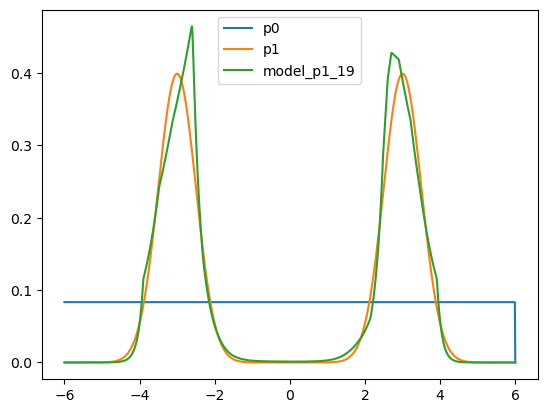

T:  18
Time:  19 iteration:  0 loss:  2.1960535049438477 acc:  0.5 kl_div:  tensor(-9.6120, device='cuda:0') mse:  tensor(2.4173, device='cuda:0') js_div:  [0.00494335]
Time:  19 iteration:  100 loss:  1.522516131401062 acc:  0.4998 kl_div:  tensor(26800.5977, device='cuda:0') mse:  tensor(1.6747, device='cuda:0') js_div:  [0.01365491]
Time:  19 iteration:  200 loss:  1.503248929977417 acc:  0.4951 kl_div:  tensor(121.4296, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [7.360261e-05]
Time:  19 iteration:  300 loss:  1.502009630203247 acc:  0.49825 kl_div:  tensor(3.7648, device='cuda:0') mse:  tensor(3.8403e-05, device='cuda:0') js_div:  [5.9369522e-05]
Time:  19 iteration:  400 loss:  1.5060054063796997 acc:  0.49615 kl_div:  tensor(37.3599, device='cuda:0') mse:  tensor(4.8698e-05, device='cuda:0') js_div:  [4.5742683e-05]
Time:  19 iteration:  500 loss:  1.5028166770935059 acc:  0.49815 kl_div:  tensor(13.2209, device='cuda:0') mse:  tensor(3.4372e-05, device='cuda

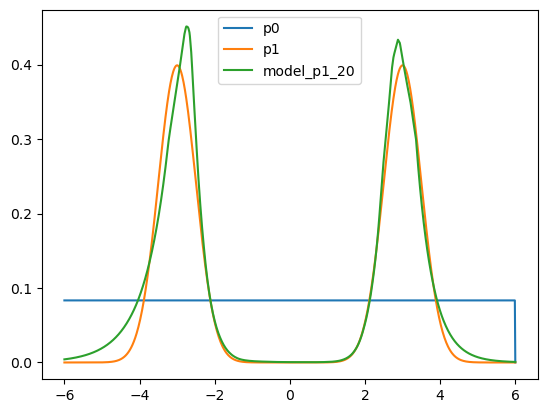

T:  19


In [22]:
model = train(u,30000,lr=1e-4)

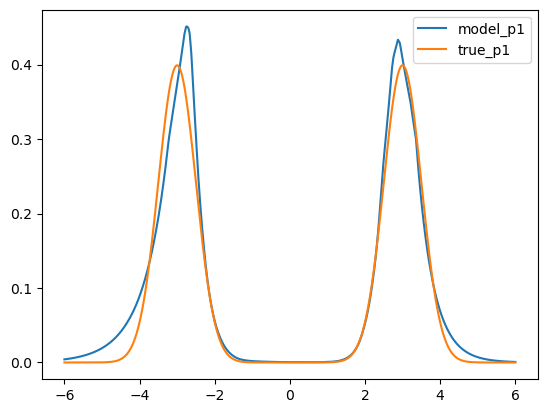

In [23]:
x=np.linspace(-6, 6, 1000)
x=torch.Tensor(x).cuda().unsqueeze(1)
true_energy=p_1.log_prob(x.detach().cpu()).squeeze().numpy()
energy=model(x).detach().cpu().squeeze().numpy()
x=x.cpu().squeeze().numpy()
plt.plot(x, np.exp(energy),label='model_p1')
plt.plot(x, np.exp(true_energy), label='true_p1')
plt.legend()

## Now with BAR correction at each time step

Time:  0 iteration:  0 loss:  2.4854867458343506 acc:  0.5 kl_div:  tensor(-8.9858, device='cuda:0') mse:  tensor(0.7395, device='cuda:0') js_div:  [0.00954322]
Time:  0 iteration:  100 loss:  1.5745646953582764 acc:  0.5034 kl_div:  tensor(15729.4209, device='cuda:0') mse:  tensor(0.4897, device='cuda:0') js_div:  [0.06145984]
Time:  0 iteration:  200 loss:  1.4415372610092163 acc:  0.5029 kl_div:  tensor(697.9992, device='cuda:0') mse:  tensor(0.0075, device='cuda:0') js_div:  [0.01240964]
Time:  0 iteration:  300 loss:  1.392511010169983 acc:  0.50245 kl_div:  tensor(281.2488, device='cuda:0') mse:  tensor(0.0016, device='cuda:0') js_div:  [0.00918739]
Time:  0 iteration:  400 loss:  1.3858027458190918 acc:  0.50745 kl_div:  tensor(61.4833, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00159727]
Time:  0 iteration:  500 loss:  1.3852707147598267 acc:  0.51065 kl_div:  tensor(10.9853, device='cuda:0') mse:  tensor(8.9705e-06, device='cuda:0') js_div:  [0.00013272

/tmp/ipykernel_1383439/462964913.py:66: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  model.partition = nn.Parameter(torch.tensor([torch.exp(torch.tensor([free_energy.x]))], requires_grad=True,device="cuda"))


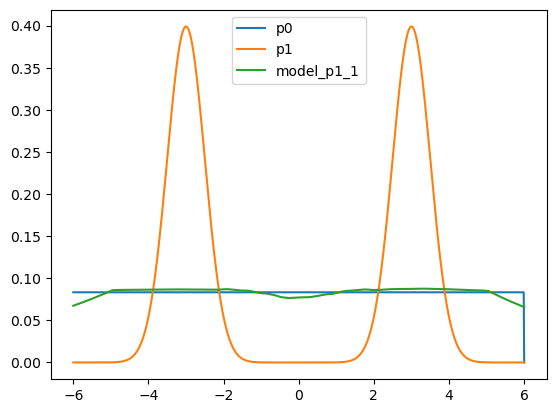

T:  0
Time:  1 iteration:  0 loss:  2.9592441162783327 acc:  0.5 kl_div:  tensor(-9.5428, device='cuda:0') mse:  tensor(2.2816, device='cuda:0') js_div:  [0.00979395]
Time:  1 iteration:  100 loss:  1.6093992010652016 acc:  0.5035 kl_div:  tensor(38103.3633, device='cuda:0') mse:  tensor(1.8929, device='cuda:0') js_div:  [0.12401053]
Time:  1 iteration:  200 loss:  1.505259095712523 acc:  0.50265 kl_div:  tensor(607.8806, device='cuda:0') mse:  tensor(0.0067, device='cuda:0') js_div:  [0.00492982]
Time:  1 iteration:  300 loss:  1.4284299905068458 acc:  0.50285 kl_div:  tensor(384.3270, device='cuda:0') mse:  tensor(0.0028, device='cuda:0') js_div:  [0.0067587]
Time:  1 iteration:  400 loss:  1.3958572167029795 acc:  0.502 kl_div:  tensor(201.3421, device='cuda:0') mse:  tensor(0.0009, device='cuda:0') js_div:  [0.00537632]
Time:  1 iteration:  500 loss:  1.3882091843200877 acc:  0.50305 kl_div:  tensor(59.4238, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.0013811

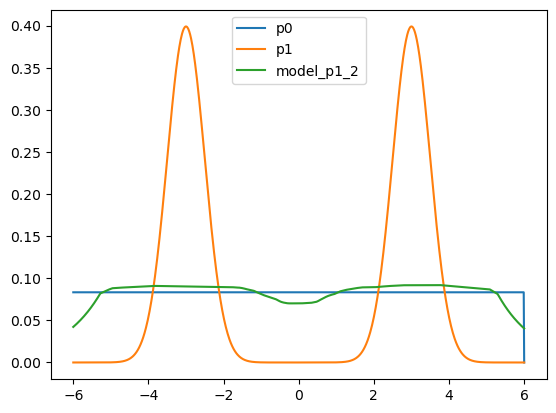

T:  1
Time:  2 iteration:  0 loss:  2.8683846402249307 acc:  0.5 kl_div:  tensor(-9.4510, device='cuda:0') mse:  tensor(1.7676, device='cuda:0') js_div:  [0.005533]
Time:  2 iteration:  100 loss:  1.5982995600547176 acc:  0.50355 kl_div:  tensor(32023.6250, device='cuda:0') mse:  tensor(1.4040, device='cuda:0') js_div:  [0.10773279]
Time:  2 iteration:  200 loss:  1.4857075608412944 acc:  0.50285 kl_div:  tensor(625.5452, device='cuda:0') mse:  tensor(0.0068, device='cuda:0') js_div:  [0.00663233]
Time:  2 iteration:  300 loss:  1.416537470878434 acc:  0.49785 kl_div:  tensor(359.7180, device='cuda:0') mse:  tensor(0.0024, device='cuda:0') js_div:  [0.00839905]
Time:  2 iteration:  400 loss:  1.3932905008378635 acc:  0.49395 kl_div:  tensor(139.2204, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00444098]
Time:  2 iteration:  500 loss:  1.38993312478238 acc:  0.49505 kl_div:  tensor(31.5872, device='cuda:0') mse:  tensor(5.0443e-05, device='cuda:0') js_div:  [0.000

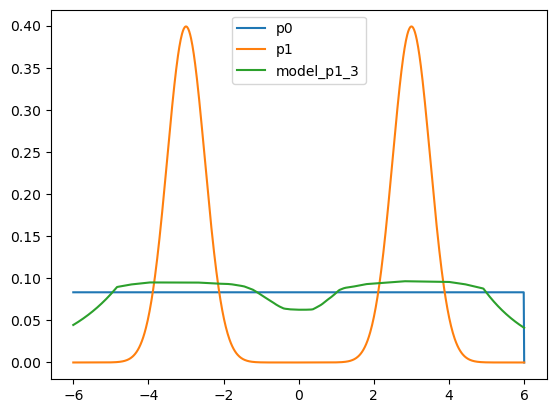

T:  2
Time:  3 iteration:  0 loss:  2.5307365195034515 acc:  0.5 kl_div:  tensor(-9.0740, device='cuda:0') mse:  tensor(0.7900, device='cuda:0') js_div:  [0.00234615]
Time:  3 iteration:  100 loss:  1.6024668508454198 acc:  0.50255 kl_div:  tensor(17114.4160, device='cuda:0') mse:  tensor(0.5251, device='cuda:0') js_div:  [0.072712]
Time:  3 iteration:  200 loss:  1.5020434094677118 acc:  0.5026 kl_div:  tensor(510.0269, device='cuda:0') mse:  tensor(0.0058, device='cuda:0') js_div:  [0.00648565]
Time:  3 iteration:  300 loss:  1.4274306495529747 acc:  0.49605 kl_div:  tensor(395.0585, device='cuda:0') mse:  tensor(0.0030, device='cuda:0') js_div:  [0.00845977]
Time:  3 iteration:  400 loss:  1.3978127116869108 acc:  0.4919 kl_div:  tensor(160.0022, device='cuda:0') mse:  tensor(0.0007, device='cuda:0') js_div:  [0.00529036]
Time:  3 iteration:  500 loss:  1.3916137020646062 acc:  0.493 kl_div:  tensor(39.9599, device='cuda:0') mse:  tensor(8.8352e-05, device='cuda:0') js_div:  [0.0011

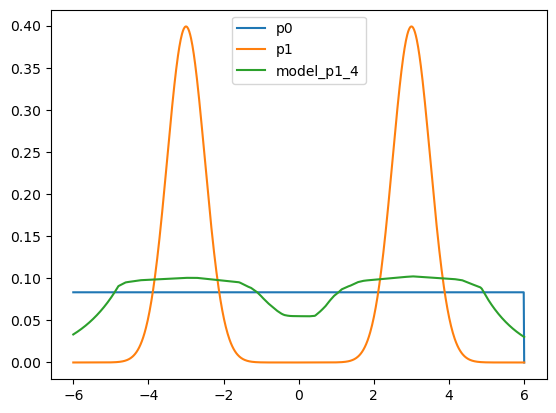

T:  3
Time:  4 iteration:  0 loss:  2.8330697960323246 acc:  0.5 kl_div:  tensor(-9.4377, device='cuda:0') mse:  tensor(1.6140, device='cuda:0') js_div:  [0.00151906]
Time:  4 iteration:  100 loss:  1.5445463526476448 acc:  0.5016 kl_div:  tensor(31313.9199, device='cuda:0') mse:  tensor(1.2989, device='cuda:0') js_div:  [0.07237074]
Time:  4 iteration:  200 loss:  1.4547935326414498 acc:  0.50135 kl_div:  tensor(399.0414, device='cuda:0') mse:  tensor(0.0037, device='cuda:0') js_div:  [0.00938559]
Time:  4 iteration:  300 loss:  1.4106085041479368 acc:  0.49065 kl_div:  tensor(219.1184, device='cuda:0') mse:  tensor(0.0012, device='cuda:0') js_div:  [0.00674436]
Time:  4 iteration:  400 loss:  1.3980594431238837 acc:  0.48585 kl_div:  tensor(69.5870, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00218888]
Time:  4 iteration:  500 loss:  1.3941621554095995 acc:  0.48915 kl_div:  tensor(12.0727, device='cuda:0') mse:  tensor(2.3505e-05, device='cuda:0') js_div:  [0.

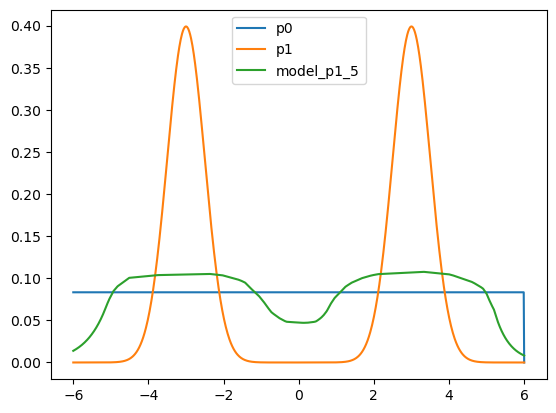

T:  4
Time:  5 iteration:  0 loss:  2.593590081500656 acc:  0.5 kl_div:  tensor(-9.1832, device='cuda:0') mse:  tensor(1.0090, device='cuda:0') js_div:  [0.00395907]
Time:  5 iteration:  100 loss:  1.5451038829320047 acc:  0.5001 kl_div:  tensor(21618.0234, device='cuda:0') mse:  tensor(0.7586, device='cuda:0') js_div:  [0.05976192]
Time:  5 iteration:  200 loss:  1.4641229317902011 acc:  0.4916 kl_div:  tensor(372.6334, device='cuda:0') mse:  tensor(0.0033, device='cuda:0') js_div:  [0.00846205]
Time:  5 iteration:  300 loss:  1.419615744279279 acc:  0.48965 kl_div:  tensor(229.5707, device='cuda:0') mse:  tensor(0.0013, device='cuda:0') js_div:  [0.00712538]
Time:  5 iteration:  400 loss:  1.405334092754014 acc:  0.48635 kl_div:  tensor(67.6271, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00227851]
Time:  5 iteration:  500 loss:  1.401029041443609 acc:  0.4853 kl_div:  tensor(10.8084, device='cuda:0') mse:  tensor(2.5950e-05, device='cuda:0') js_div:  [0.000400

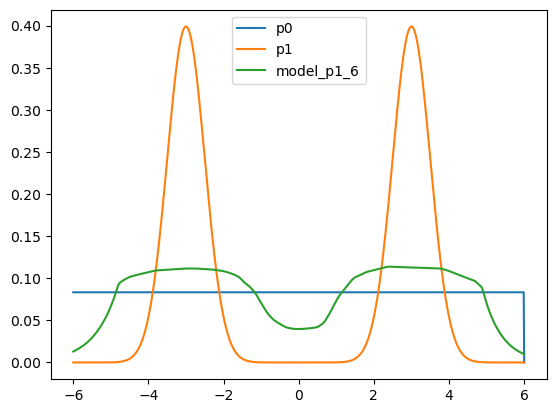

T:  5
Time:  6 iteration:  0 loss:  2.4222230654716412 acc:  0.5 kl_div:  tensor(-8.9972, device='cuda:0') mse:  tensor(0.6548, device='cuda:0') js_div:  [0.00018776]
Time:  6 iteration:  100 loss:  1.5712472290835695 acc:  0.4966 kl_div:  tensor(14787.5039, device='cuda:0') mse:  tensor(0.4289, device='cuda:0') js_div:  [0.05571137]
Time:  6 iteration:  200 loss:  1.5022285868507694 acc:  0.49075 kl_div:  tensor(410.7064, device='cuda:0') mse:  tensor(0.0037, device='cuda:0') js_div:  [0.00499554]
Time:  6 iteration:  300 loss:  1.4437328530573552 acc:  0.4896 kl_div:  tensor(274.5817, device='cuda:0') mse:  tensor(0.0018, device='cuda:0') js_div:  [0.00605415]
Time:  6 iteration:  400 loss:  1.4170026594512994 acc:  0.48785 kl_div:  tensor(124.8304, device='cuda:0') mse:  tensor(0.0006, device='cuda:0') js_div:  [0.00394434]
Time:  6 iteration:  500 loss:  1.4055933939792997 acc:  0.4877 kl_div:  tensor(40.9629, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00135

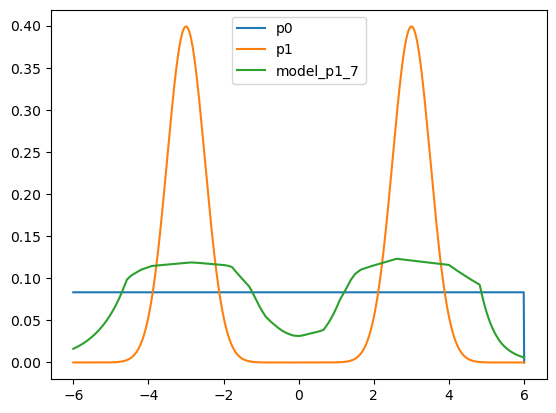

T:  6
Time:  7 iteration:  0 loss:  3.052738056111519 acc:  0.5 kl_div:  tensor(-9.7792, device='cuda:0') mse:  tensor(3.6964, device='cuda:0') js_div:  [0.01026447]
Time:  7 iteration:  100 loss:  1.6336063996250703 acc:  0.499 kl_div:  tensor(43873.4141, device='cuda:0') mse:  tensor(2.9919, device='cuda:0') js_div:  [0.07453963]
Time:  7 iteration:  200 loss:  1.532250858306679 acc:  0.4955 kl_div:  tensor(1069.3481, device='cuda:0') mse:  tensor(0.0105, device='cuda:0') js_div:  [0.00015147]
Time:  7 iteration:  300 loss:  1.4747196063364318 acc:  0.48945 kl_div:  tensor(286.0512, device='cuda:0') mse:  tensor(0.0020, device='cuda:0') js_div:  [0.00451754]
Time:  7 iteration:  400 loss:  1.4327770262869126 acc:  0.4878 kl_div:  tensor(192.1608, device='cuda:0') mse:  tensor(0.0011, device='cuda:0') js_div:  [0.00538001]
Time:  7 iteration:  500 loss:  1.411133205663821 acc:  0.4854 kl_div:  tensor(72.3666, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00272588]

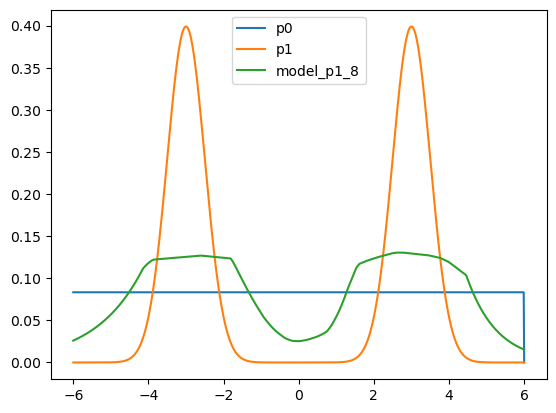

T:  7
Time:  8 iteration:  0 loss:  2.724585796538201 acc:  0.5 kl_div:  tensor(-9.4353, device='cuda:0') mse:  tensor(1.5928, device='cuda:0') js_div:  [0.00097496]
Time:  8 iteration:  100 loss:  1.5763892813778866 acc:  0.50055 kl_div:  tensor(28341.4824, device='cuda:0') mse:  tensor(1.2151, device='cuda:0') js_div:  [0.06050671]
Time:  8 iteration:  200 loss:  1.5127627820022418 acc:  0.49515 kl_div:  tensor(285.9256, device='cuda:0') mse:  tensor(0.0024, device='cuda:0') js_div:  [0.00331842]
Time:  8 iteration:  300 loss:  1.4715835470698355 acc:  0.48735 kl_div:  tensor(234.6055, device='cuda:0') mse:  tensor(0.0015, device='cuda:0') js_div:  [0.00400364]
Time:  8 iteration:  400 loss:  1.4338070924492796 acc:  0.4869 kl_div:  tensor(155.2104, device='cuda:0') mse:  tensor(0.0008, device='cuda:0') js_div:  [0.00402278]
Time:  8 iteration:  500 loss:  1.4166887219278492 acc:  0.4801 kl_div:  tensor(65.4663, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00196

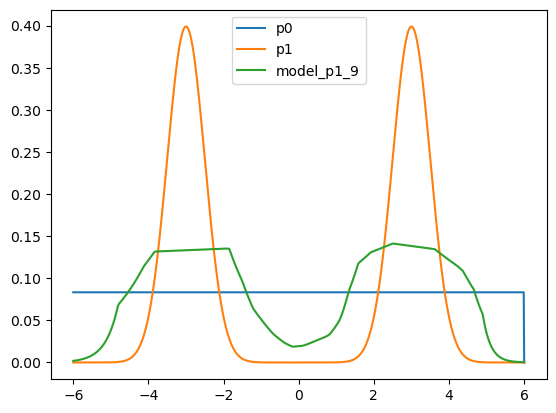

T:  8
Time:  9 iteration:  0 loss:  2.33101154709312 acc:  0.5 kl_div:  tensor(-8.9919, device='cuda:0') mse:  tensor(0.6807, device='cuda:0') js_div:  [0.00333301]
Time:  9 iteration:  100 loss:  1.5526902103002227 acc:  0.4898 kl_div:  tensor(14871.7520, device='cuda:0') mse:  tensor(0.4546, device='cuda:0') js_div:  [0.0387521]
Time:  9 iteration:  200 loss:  1.5105317360436104 acc:  0.48765 kl_div:  tensor(186.7094, device='cuda:0') mse:  tensor(0.0015, device='cuda:0') js_div:  [0.00329157]
Time:  9 iteration:  300 loss:  1.4717982782776495 acc:  0.48545 kl_div:  tensor(187.9465, device='cuda:0') mse:  tensor(0.0011, device='cuda:0') js_div:  [0.00345523]
Time:  9 iteration:  400 loss:  1.4445386379239493 acc:  0.48155 kl_div:  tensor(121.0008, device='cuda:0') mse:  tensor(0.0006, device='cuda:0') js_div:  [0.00322723]
Time:  9 iteration:  500 loss:  1.4296767800805776 acc:  0.48005 kl_div:  tensor(49.3181, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.001588

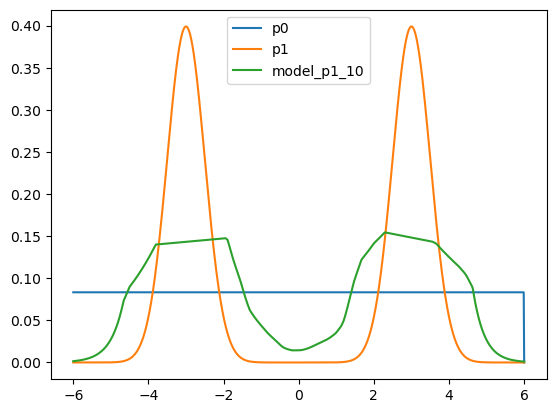

T:  9
Time:  10 iteration:  0 loss:  2.2627768107870305 acc:  0.5 kl_div:  tensor(-8.9572, device='cuda:0') mse:  tensor(0.6139, device='cuda:0') js_div:  [0.00116751]
Time:  10 iteration:  100 loss:  1.5317859326339591 acc:  0.48715 kl_div:  tensor(13463.4727, device='cuda:0') mse:  tensor(0.3999, device='cuda:0') js_div:  [0.02825666]
Time:  10 iteration:  200 loss:  1.4960544935033544 acc:  0.48565 kl_div:  tensor(208.4601, device='cuda:0') mse:  tensor(0.0013, device='cuda:0') js_div:  [0.00298821]
Time:  10 iteration:  300 loss:  1.4657239648198788 acc:  0.4816 kl_div:  tensor(134.7066, device='cuda:0') mse:  tensor(0.0007, device='cuda:0') js_div:  [0.00276538]
Time:  10 iteration:  400 loss:  1.4485357468777877 acc:  0.47855 kl_div:  tensor(72.4248, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00187529]
Time:  10 iteration:  500 loss:  1.4352093384550166 acc:  0.47835 kl_div:  tensor(32.5438, device='cuda:0') mse:  tensor(9.8892e-05, device='cuda:0') js_div

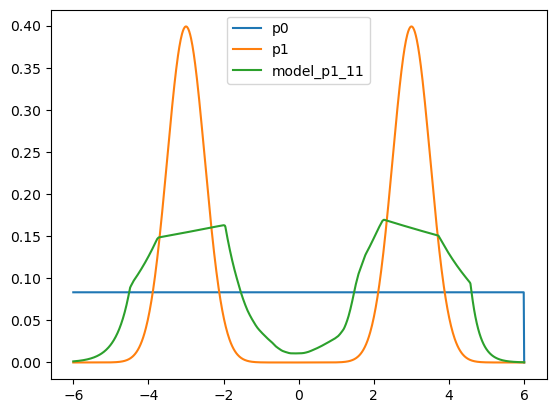

T:  10
Time:  11 iteration:  0 loss:  2.5392714226910664 acc:  0.5 kl_div:  tensor(-9.3686, device='cuda:0') mse:  tensor(1.5330, device='cuda:0') js_div:  [0.00690783]
Time:  11 iteration:  100 loss:  1.5704026146071473 acc:  0.4959 kl_div:  tensor(23625.0273, device='cuda:0') mse:  tensor(1.1125, device='cuda:0') js_div:  [0.04425846]
Time:  11 iteration:  200 loss:  1.527349298717641 acc:  0.48665 kl_div:  tensor(476.3430, device='cuda:0') mse:  tensor(0.0024, device='cuda:0') js_div:  [0.00027484]
Time:  11 iteration:  300 loss:  1.514199193789595 acc:  0.4856 kl_div:  tensor(120.1705, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00099093]
Time:  11 iteration:  400 loss:  1.490258810260435 acc:  0.48125 kl_div:  tensor(113.4013, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.001457]
Time:  11 iteration:  500 loss:  1.4689508408607992 acc:  0.476 kl_div:  tensor(94.4671, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.0016

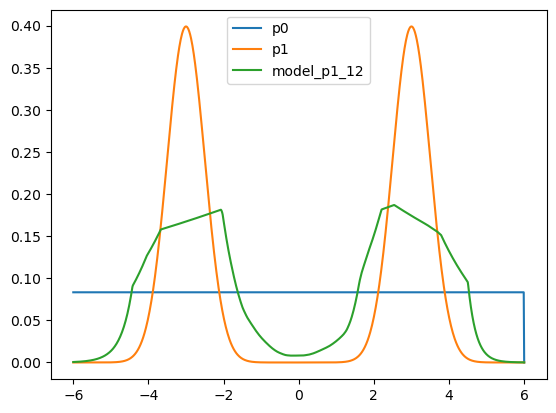

T:  11
Time:  12 iteration:  0 loss:  2.2908899077321663 acc:  0.5 kl_div:  tensor(-9.1216, device='cuda:0') mse:  tensor(0.8414, device='cuda:0') js_div:  [0.00031841]
Time:  12 iteration:  100 loss:  1.5377572293931028 acc:  0.48465 kl_div:  tensor(16568.1523, device='cuda:0') mse:  tensor(0.5695, device='cuda:0') js_div:  [0.02347432]
Time:  12 iteration:  200 loss:  1.5162805586483754 acc:  0.48255 kl_div:  tensor(66.7031, device='cuda:0') mse:  tensor(0.0006, device='cuda:0') js_div:  [0.00173172]
Time:  12 iteration:  300 loss:  1.492208802345489 acc:  0.47865 kl_div:  tensor(127.1243, device='cuda:0') mse:  tensor(0.0007, device='cuda:0') js_div:  [0.00187607]
Time:  12 iteration:  400 loss:  1.4700005608418933 acc:  0.4776 kl_div:  tensor(94.6310, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00194851]
Time:  12 iteration:  500 loss:  1.4524811086529255 acc:  0.47765 kl_div:  tensor(49.0965, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0

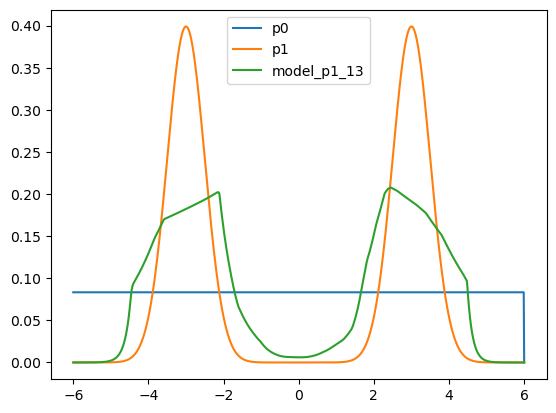

T:  12
Time:  13 iteration:  0 loss:  2.4415886469243655 acc:  0.5 kl_div:  tensor(-9.3872, device='cuda:0') mse:  tensor(1.4293, device='cuda:0') js_div:  [0.00022715]
Time:  13 iteration:  100 loss:  1.5514589459610737 acc:  0.4804 kl_div:  tensor(24475.1875, device='cuda:0') mse:  tensor(1.0581, device='cuda:0') js_div:  [0.02779725]
Time:  13 iteration:  200 loss:  1.5296151866268142 acc:  0.47985 kl_div:  tensor(-19.6202, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00095557]
Time:  13 iteration:  300 loss:  1.511366059178236 acc:  0.47715 kl_div:  tensor(96.0940, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.00090436]
Time:  13 iteration:  400 loss:  1.495967566261601 acc:  0.4757 kl_div:  tensor(83.2864, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.00112098]
Time:  13 iteration:  500 loss:  1.4838572608095182 acc:  0.4757 kl_div:  tensor(65.3119, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00

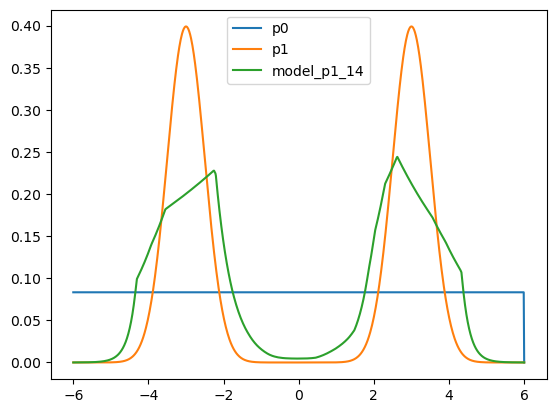

T:  13
Time:  14 iteration:  0 loss:  2.242387146384512 acc:  0.5 kl_div:  tensor(-9.1858, device='cuda:0') mse:  tensor(1.2679, device='cuda:0') js_div:  [0.01846155]
Time:  14 iteration:  100 loss:  1.533459307057047 acc:  0.4774 kl_div:  tensor(20437.4883, device='cuda:0') mse:  tensor(0.9469, device='cuda:0') js_div:  [0.0424373]
Time:  14 iteration:  200 loss:  1.511663453996529 acc:  0.47205 kl_div:  tensor(72.5518, device='cuda:0') mse:  tensor(0.0007, device='cuda:0') js_div:  [0.00158268]
Time:  14 iteration:  300 loss:  1.4976293320686478 acc:  0.4751 kl_div:  tensor(101.0083, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00118114]
Time:  14 iteration:  400 loss:  1.480394457297693 acc:  0.47645 kl_div:  tensor(70.7088, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.00120713]
Time:  14 iteration:  500 loss:  1.47008070730169 acc:  0.4756 kl_div:  tensor(52.2544, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.0010988

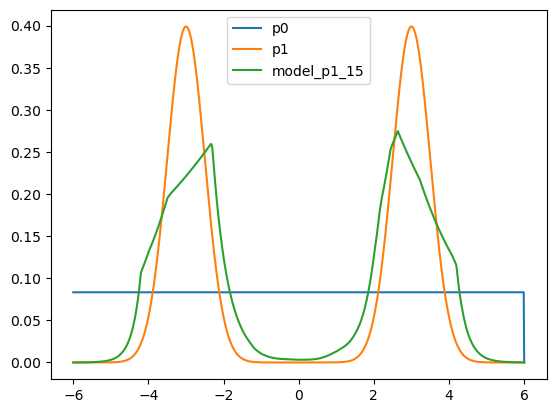

T:  14
Time:  15 iteration:  0 loss:  1.8998773181619366 acc:  0.5 kl_div:  tensor(-8.7675, device='cuda:0') mse:  tensor(0.4343, device='cuda:0') js_div:  [0.00330897]
Time:  15 iteration:  100 loss:  1.5243396199135972 acc:  0.47015 kl_div:  tensor(8031.9434, device='cuda:0') mse:  tensor(0.2150, device='cuda:0') js_div:  [0.00812777]
Time:  15 iteration:  200 loss:  1.5212225402676829 acc:  0.47255 kl_div:  tensor(70.3357, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.00065074]
Time:  15 iteration:  300 loss:  1.4958403279244143 acc:  0.4743 kl_div:  tensor(61.4458, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00074924]
Time:  15 iteration:  400 loss:  1.4863791341515946 acc:  0.4736 kl_div:  tensor(54.7296, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00085626]
Time:  15 iteration:  500 loss:  1.4683253433638273 acc:  0.47545 kl_div:  tensor(34.5625, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.0

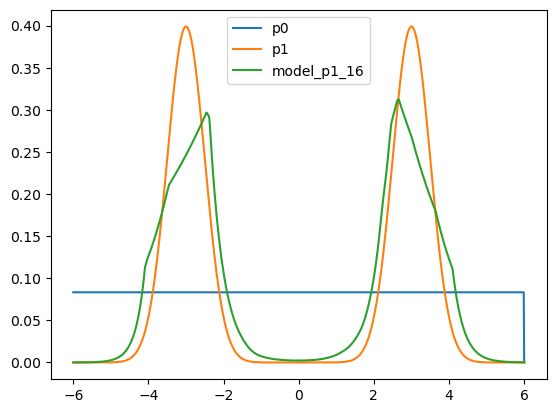

T:  15
Time:  16 iteration:  0 loss:  2.1883737108032837 acc:  0.5 kl_div:  tensor(-9.2847, device='cuda:0') mse:  tensor(1.1953, device='cuda:0') js_div:  [0.00186934]
Time:  16 iteration:  100 loss:  1.536778655139091 acc:  0.46975 kl_div:  tensor(18276.9961, device='cuda:0') mse:  tensor(0.7816, device='cuda:0') js_div:  [0.0141539]
Time:  16 iteration:  200 loss:  1.5270661540661177 acc:  0.4725 kl_div:  tensor(7.1803, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00044481]
Time:  16 iteration:  300 loss:  1.5184889910042134 acc:  0.46985 kl_div:  tensor(53.6948, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.0002545]
Time:  16 iteration:  400 loss:  1.5147299432581265 acc:  0.4705 kl_div:  tensor(44.7834, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00031204]
Time:  16 iteration:  500 loss:  1.504732129330738 acc:  0.47075 kl_div:  tensor(32.0222, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00034

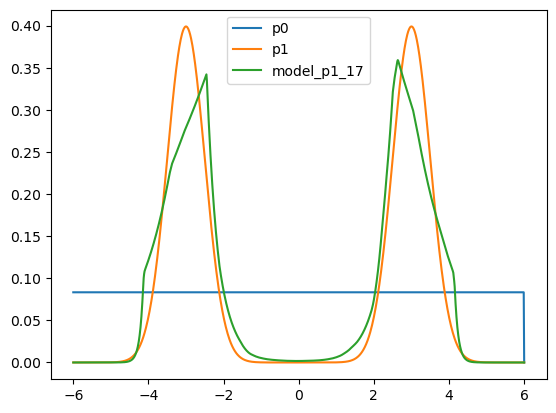

T:  16
Time:  17 iteration:  0 loss:  2.0775851835938304 acc:  0.5 kl_div:  tensor(-9.2382, device='cuda:0') mse:  tensor(1.0917, device='cuda:0') js_div:  [0.00200073]
Time:  17 iteration:  100 loss:  1.5435046215798276 acc:  0.46855 kl_div:  tensor(15837.5215, device='cuda:0') mse:  tensor(0.6685, device='cuda:0') js_div:  [0.01093537]
Time:  17 iteration:  200 loss:  1.532241975694625 acc:  0.47025 kl_div:  tensor(63.3803, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00012674]
Time:  17 iteration:  300 loss:  1.5190096527263426 acc:  0.46905 kl_div:  tensor(36.2390, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00015907]
Time:  17 iteration:  400 loss:  1.518431445985813 acc:  0.4697 kl_div:  tensor(22.8920, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00020869]
Time:  17 iteration:  500 loss:  1.5055634527341095 acc:  0.4712 kl_div:  tensor(32.9710, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00

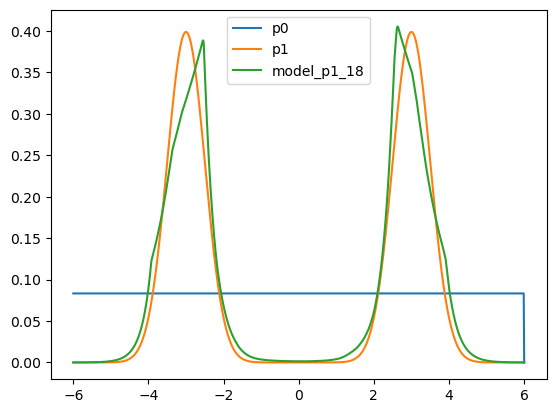

T:  17
Time:  18 iteration:  0 loss:  1.925264093342984 acc:  0.5 kl_div:  tensor(-9.0621, device='cuda:0') mse:  tensor(0.8384, device='cuda:0') js_div:  [0.00767184]
Time:  18 iteration:  100 loss:  1.5443596865463693 acc:  0.4677 kl_div:  tensor(11779.5264, device='cuda:0') mse:  tensor(0.4614, device='cuda:0') js_div:  [0.01230558]
Time:  18 iteration:  200 loss:  1.5342983197709774 acc:  0.4682 kl_div:  tensor(-21.0943, device='cuda:0') mse:  tensor(6.3789e-05, device='cuda:0') js_div:  [9.671391e-05]
Time:  18 iteration:  300 loss:  1.5250304647450945 acc:  0.4678 kl_div:  tensor(26.7677, device='cuda:0') mse:  tensor(5.6938e-05, device='cuda:0') js_div:  [6.764224e-05]
Time:  18 iteration:  400 loss:  1.5215155109079617 acc:  0.4663 kl_div:  tensor(16.4023, device='cuda:0') mse:  tensor(7.2507e-05, device='cuda:0') js_div:  [0.00010791]
Time:  18 iteration:  500 loss:  1.5153684719816591 acc:  0.4653 kl_div:  tensor(33.2463, device='cuda:0') mse:  tensor(0.0001, device='cuda:0')

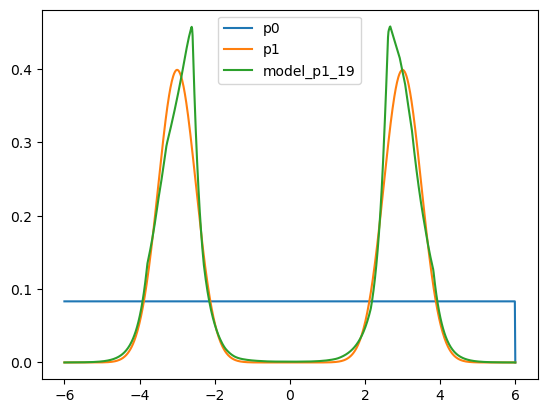

T:  18
Time:  19 iteration:  0 loss:  2.0980691822003585 acc:  0.5 kl_div:  tensor(-9.4839, device='cuda:0') mse:  tensor(1.9878, device='cuda:0') js_div:  [0.00889287]
Time:  19 iteration:  100 loss:  1.5057279058352138 acc:  0.4959 kl_div:  tensor(22701.7422, device='cuda:0') mse:  tensor(1.3253, device='cuda:0') js_div:  [0.014761]
Time:  19 iteration:  200 loss:  1.511144529605203 acc:  0.4969 kl_div:  tensor(53.1258, device='cuda:0') mse:  tensor(4.4992e-05, device='cuda:0') js_div:  [1.5768343e-05]
Time:  19 iteration:  300 loss:  1.5110393076305246 acc:  0.49935 kl_div:  tensor(14.6531, device='cuda:0') mse:  tensor(3.1748e-05, device='cuda:0') js_div:  [4.1805495e-05]
Time:  19 iteration:  400 loss:  1.5076498253015223 acc:  0.49525 kl_div:  tensor(23.9910, device='cuda:0') mse:  tensor(3.8242e-05, device='cuda:0') js_div:  [4.6018344e-05]
Time:  19 iteration:  500 loss:  1.5073894049380154 acc:  0.4968 kl_div:  tensor(14.0244, device='cuda:0') mse:  tensor(4.1047e-05, device='

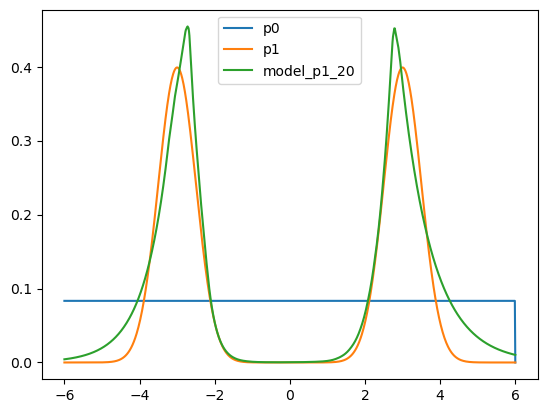

T:  19


In [24]:
model = train(u,30000,bar=True) 

## NCE with exponential loss

Time:  0 iteration:  0 loss:  4.7049784660339355 acc:  0.5 kl_div:  tensor(-9.6763, device='cuda:0') mse:  tensor(2.9996, device='cuda:0') js_div:  [0.01018357]


Time:  0 iteration:  100 loss:  2.291721820831299 acc:  0.5053 kl_div:  tensor(42289.8906, device='cuda:0') mse:  tensor(2.4308, device='cuda:0') js_div:  [0.11351657]
Time:  0 iteration:  200 loss:  2.1081695556640625 acc:  0.50265 kl_div:  tensor(1178.0685, device='cuda:0') mse:  tensor(0.0153, device='cuda:0') js_div:  [0.00448126]
Time:  0 iteration:  300 loss:  2.025048017501831 acc:  0.5028 kl_div:  tensor(404.2924, device='cuda:0') mse:  tensor(0.0028, device='cuda:0') js_div:  [0.0092766]
Time:  0 iteration:  400 loss:  2.002779483795166 acc:  0.50155 kl_div:  tensor(147.9273, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00429533]
Time:  0 iteration:  500 loss:  1.99991774559021 acc:  0.5031 kl_div:  tensor(34.4804, device='cuda:0') mse:  tensor(4.7580e-05, device='cuda:0') js_div:  [0.00057863]
Time:  0 iteration:  600 loss:  1.999428391456604 acc:  0.50485 kl_div:  tensor(6.3385, device='cuda:0') mse:  tensor(4.3815e-06, device='cuda:0') js_div:  [6.9087

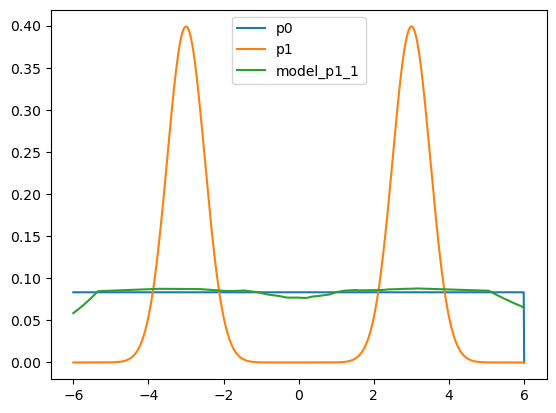

T:  0
Time:  1 iteration:  0 loss:  4.227597236633301 acc:  0.5 kl_div:  tensor(-9.4133, device='cuda:0') mse:  tensor(2.0473, device='cuda:0') js_div:  [0.01928328]
Time:  1 iteration:  100 loss:  2.201172351837158 acc:  0.50205 kl_div:  tensor(35300.6953, device='cuda:0') mse:  tensor(1.7358, device='cuda:0') js_div:  [0.10539778]
Time:  1 iteration:  200 loss:  2.0666706562042236 acc:  0.50255 kl_div:  tensor(552.5309, device='cuda:0') mse:  tensor(0.0058, device='cuda:0') js_div:  [0.01172184]
Time:  1 iteration:  300 loss:  2.012216329574585 acc:  0.5026 kl_div:  tensor(268.5140, device='cuda:0') mse:  tensor(0.0015, device='cuda:0') js_div:  [0.00796076]
Time:  1 iteration:  400 loss:  2.0017142295837402 acc:  0.49945 kl_div:  tensor(84.2964, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00230413]
Time:  1 iteration:  500 loss:  2.000617027282715 acc:  0.50155 kl_div:  tensor(15.6666, device='cuda:0') mse:  tensor(1.4742e-05, device='cuda:0') js_div:  [0.0002

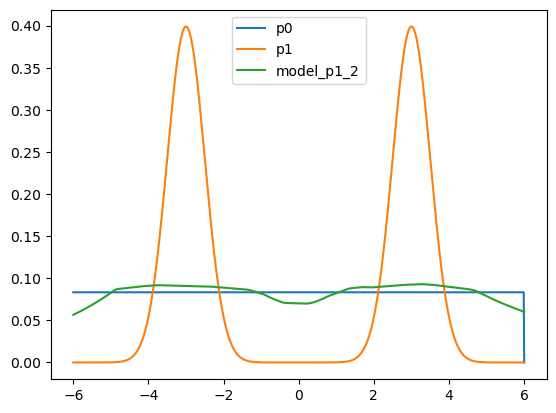

T:  1
Time:  2 iteration:  0 loss:  3.8567023277282715 acc:  0.5 kl_div:  tensor(-9.2447, device='cuda:0') mse:  tensor(1.1141, device='cuda:0') js_div:  [0.00248466]
Time:  2 iteration:  100 loss:  2.211883068084717 acc:  0.5027 kl_div:  tensor(22356.8496, device='cuda:0') mse:  tensor(0.8077, device='cuda:0') js_div:  [0.06829275]
Time:  2 iteration:  200 loss:  2.087393283843994 acc:  0.50165 kl_div:  tensor(604.7578, device='cuda:0') mse:  tensor(0.0063, device='cuda:0') js_div:  [0.00824725]
Time:  2 iteration:  300 loss:  2.028555393218994 acc:  0.50145 kl_div:  tensor(267.0891, device='cuda:0') mse:  tensor(0.0016, device='cuda:0') js_div:  [0.00715626]
Time:  2 iteration:  400 loss:  2.0090510845184326 acc:  0.49695 kl_div:  tensor(100.6861, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00293418]
Time:  2 iteration:  500 loss:  2.0029029846191406 acc:  0.4992 kl_div:  tensor(34.5124, device='cuda:0') mse:  tensor(7.4516e-05, device='cuda:0') js_div:  [0.000

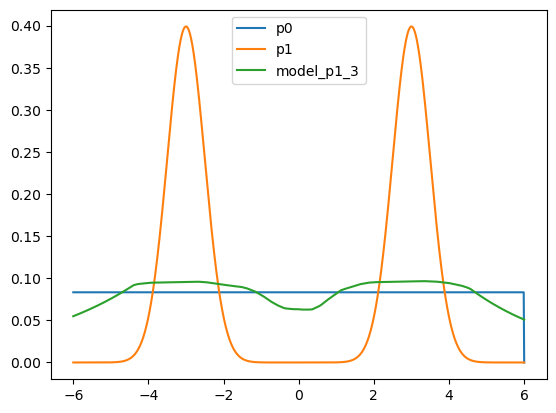

T:  2
Time:  3 iteration:  0 loss:  3.6941933631896973 acc:  0.5 kl_div:  tensor(-9.1399, device='cuda:0') mse:  tensor(0.9702, device='cuda:0') js_div:  [0.00701295]
Time:  3 iteration:  100 loss:  2.1980156898498535 acc:  0.50235 kl_div:  tensor(19839.6875, device='cuda:0') mse:  tensor(0.7003, device='cuda:0') js_div:  [0.06589516]
Time:  3 iteration:  200 loss:  2.0666768550872803 acc:  0.502 kl_div:  tensor(632.3682, device='cuda:0') mse:  tensor(0.0068, device='cuda:0') js_div:  [0.01049714]
Time:  3 iteration:  300 loss:  2.0155627727508545 acc:  0.4955 kl_div:  tensor(256.5209, device='cuda:0') mse:  tensor(0.0014, device='cuda:0') js_div:  [0.00790878]
Time:  3 iteration:  400 loss:  2.0043699741363525 acc:  0.49035 kl_div:  tensor(66.6972, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00183304]
Time:  3 iteration:  500 loss:  2.002138137817383 acc:  0.4936 kl_div:  tensor(14.9403, device='cuda:0') mse:  tensor(2.0581e-05, device='cuda:0') js_div:  [0.0003

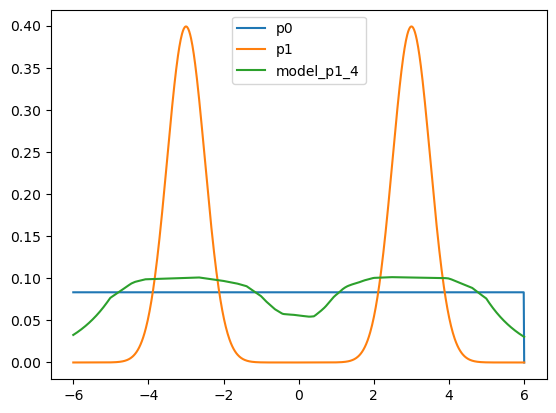

T:  3
Time:  4 iteration:  0 loss:  4.04242467880249 acc:  0.5 kl_div:  tensor(-9.3680, device='cuda:0') mse:  tensor(1.4551, device='cuda:0') js_div:  [0.00369056]
Time:  4 iteration:  100 loss:  2.232133388519287 acc:  0.50215 kl_div:  tensor(27878.4414, device='cuda:0') mse:  tensor(1.1238, device='cuda:0') js_div:  [0.08501163]
Time:  4 iteration:  200 loss:  2.103116035461426 acc:  0.5011 kl_div:  tensor(551.1202, device='cuda:0') mse:  tensor(0.0061, device='cuda:0') js_div:  [0.00872986]
Time:  4 iteration:  300 loss:  2.0372447967529297 acc:  0.49085 kl_div:  tensor(295.7902, device='cuda:0') mse:  tensor(0.0019, device='cuda:0') js_div:  [0.00736833]
Time:  4 iteration:  400 loss:  2.015477180480957 acc:  0.48925 kl_div:  tensor(111.5477, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.00332453]
Time:  4 iteration:  500 loss:  2.009129762649536 acc:  0.49045 kl_div:  tensor(32.4546, device='cuda:0') mse:  tensor(6.9843e-05, device='cuda:0') js_div:  [0.00087

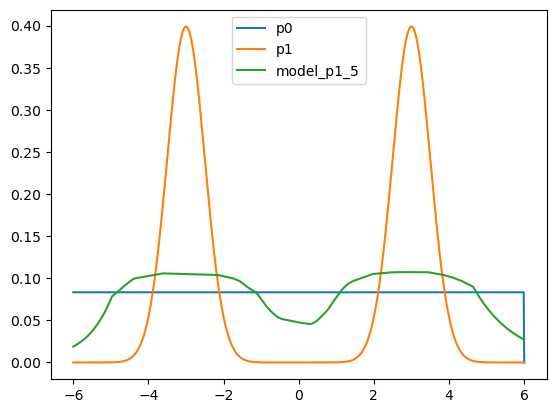

T:  4
Time:  5 iteration:  0 loss:  4.028658866882324 acc:  0.5 kl_div:  tensor(-9.3893, device='cuda:0') mse:  tensor(1.4749, device='cuda:0') js_div:  [0.00188917]
Time:  5 iteration:  100 loss:  2.246340036392212 acc:  0.50035 kl_div:  tensor(26392.5371, device='cuda:0') mse:  tensor(1.1047, device='cuda:0') js_div:  [0.07162312]
Time:  5 iteration:  200 loss:  2.116138458251953 acc:  0.50015 kl_div:  tensor(752.3353, device='cuda:0') mse:  tensor(0.0080, device='cuda:0') js_div:  [0.00452427]
Time:  5 iteration:  300 loss:  2.045584201812744 acc:  0.49055 kl_div:  tensor(274.0258, device='cuda:0') mse:  tensor(0.0018, device='cuda:0') js_div:  [0.00710764]
Time:  5 iteration:  400 loss:  2.0191237926483154 acc:  0.48865 kl_div:  tensor(114.6116, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00386078]
Time:  5 iteration:  500 loss:  2.0122203826904297 acc:  0.4863 kl_div:  tensor(33.4213, device='cuda:0') mse:  tensor(7.3252e-05, device='cuda:0') js_div:  [0.000

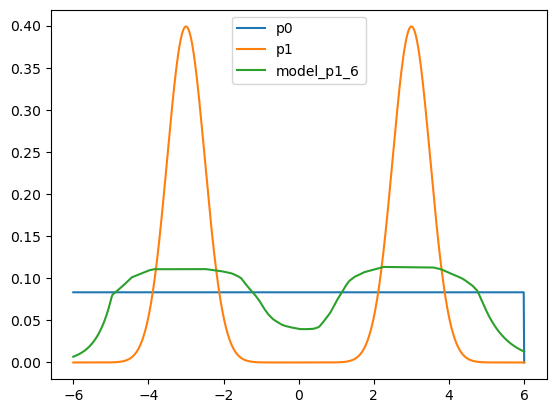

T:  5
Time:  6 iteration:  0 loss:  4.155468940734863 acc:  0.5 kl_div:  tensor(-9.4730, device='cuda:0') mse:  tensor(1.7660, device='cuda:0') js_div:  [0.00266875]
Time:  6 iteration:  100 loss:  2.2653002738952637 acc:  0.50105 kl_div:  tensor(31388.3066, device='cuda:0') mse:  tensor(1.3788, device='cuda:0') js_div:  [0.08553919]
Time:  6 iteration:  200 loss:  2.129894971847534 acc:  0.49275 kl_div:  tensor(579.6017, device='cuda:0') mse:  tensor(0.0071, device='cuda:0') js_div:  [0.00873646]
Time:  6 iteration:  300 loss:  2.061573028564453 acc:  0.4888 kl_div:  tensor(302.9266, device='cuda:0') mse:  tensor(0.0021, device='cuda:0') js_div:  [0.00735592]
Time:  6 iteration:  400 loss:  2.032595157623291 acc:  0.4862 kl_div:  tensor(123.2774, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00357171]
Time:  6 iteration:  500 loss:  2.021275043487549 acc:  0.4839 kl_div:  tensor(34.7278, device='cuda:0') mse:  tensor(8.9164e-05, device='cuda:0') js_div:  [0.001032

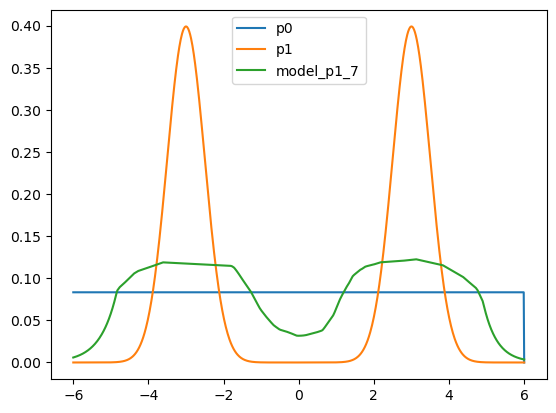

T:  6
Time:  7 iteration:  0 loss:  3.748706579208374 acc:  0.5 kl_div:  tensor(-9.2645, device='cuda:0') mse:  tensor(1.1253, device='cuda:0') js_div:  [0.00062682]
Time:  7 iteration:  100 loss:  2.252807378768921 acc:  0.49775 kl_div:  tensor(22654.5586, device='cuda:0') mse:  tensor(0.8199, device='cuda:0') js_div:  [0.0614216]
Time:  7 iteration:  200 loss:  2.135676383972168 acc:  0.49025 kl_div:  tensor(392.0486, device='cuda:0') mse:  tensor(0.0045, device='cuda:0') js_div:  [0.00832633]
Time:  7 iteration:  300 loss:  2.0660619735717773 acc:  0.48785 kl_div:  tensor(258.9271, device='cuda:0') mse:  tensor(0.0017, device='cuda:0') js_div:  [0.00666014]
Time:  7 iteration:  400 loss:  2.041196823120117 acc:  0.4818 kl_div:  tensor(106.1465, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00353497]
Time:  7 iteration:  500 loss:  2.0278358459472656 acc:  0.4837 kl_div:  tensor(28.3359, device='cuda:0') mse:  tensor(8.3387e-05, device='cuda:0') js_div:  [0.00101

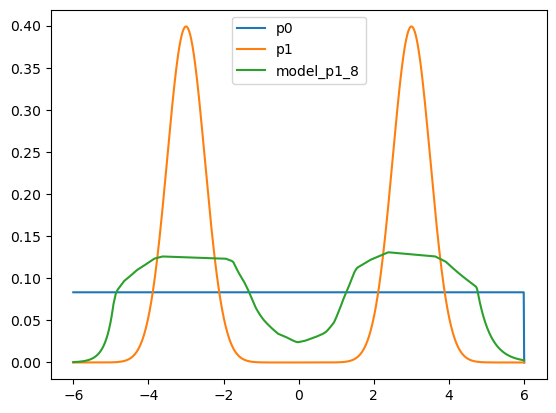

T:  7
Time:  8 iteration:  0 loss:  3.6933538913726807 acc:  0.5 kl_div:  tensor(-9.2544, device='cuda:0') mse:  tensor(1.1191, device='cuda:0') js_div:  [0.001548]
Time:  8 iteration:  100 loss:  2.210620641708374 acc:  0.4894 kl_div:  tensor(22318.4531, device='cuda:0') mse:  tensor(0.8235, device='cuda:0') js_div:  [0.04747581]
Time:  8 iteration:  200 loss:  2.1245148181915283 acc:  0.4865 kl_div:  tensor(327.7031, device='cuda:0') mse:  tensor(0.0030, device='cuda:0') js_div:  [0.00718797]
Time:  8 iteration:  300 loss:  2.0757007598876953 acc:  0.48375 kl_div:  tensor(180.0692, device='cuda:0') mse:  tensor(0.0011, device='cuda:0') js_div:  [0.00518658]
Time:  8 iteration:  400 loss:  2.0507402420043945 acc:  0.48355 kl_div:  tensor(74.9685, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00223422]
Time:  8 iteration:  500 loss:  2.038414716720581 acc:  0.4811 kl_div:  tensor(30.5605, device='cuda:0') mse:  tensor(8.2177e-05, device='cuda:0') js_div:  [0.000871

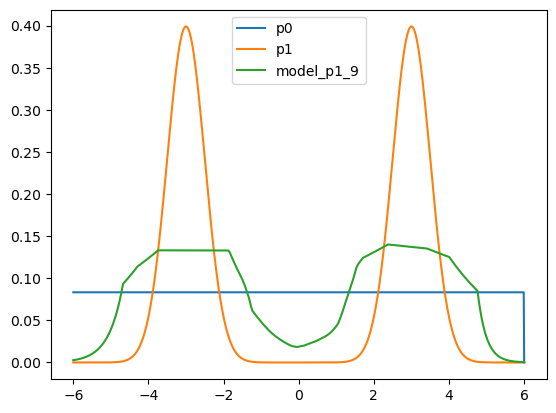

T:  8
Time:  9 iteration:  0 loss:  3.721874713897705 acc:  0.5 kl_div:  tensor(-9.3105, device='cuda:0') mse:  tensor(1.3414, device='cuda:0') js_div:  [0.0058932]
Time:  9 iteration:  100 loss:  2.266794443130493 acc:  0.49255 kl_div:  tensor(24089.4043, device='cuda:0') mse:  tensor(0.9946, device='cuda:0') js_div:  [0.05819316]
Time:  9 iteration:  200 loss:  2.1737804412841797 acc:  0.48885 kl_div:  tensor(275.9930, device='cuda:0') mse:  tensor(0.0023, device='cuda:0') js_div:  [0.00359838]
Time:  9 iteration:  300 loss:  2.113692045211792 acc:  0.48555 kl_div:  tensor(217.0087, device='cuda:0') mse:  tensor(0.0015, device='cuda:0') js_div:  [0.00406539]
Time:  9 iteration:  400 loss:  2.07669997215271 acc:  0.47925 kl_div:  tensor(137.5160, device='cuda:0') mse:  tensor(0.0007, device='cuda:0') js_div:  [0.00353104]
Time:  9 iteration:  500 loss:  2.05533504486084 acc:  0.4795 kl_div:  tensor(55.4711, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00156116]
T

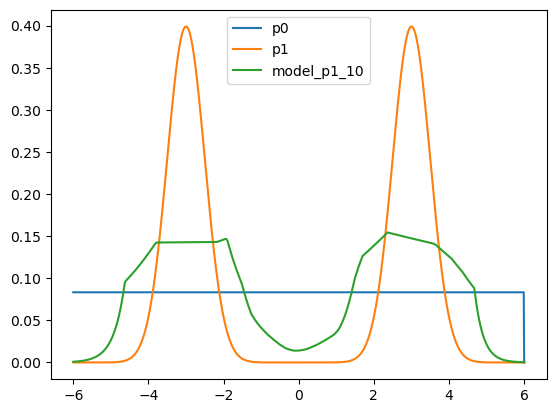

T:  9
Time:  10 iteration:  0 loss:  3.2747159004211426 acc:  0.5 kl_div:  tensor(-9.0155, device='cuda:0') mse:  tensor(0.7576, device='cuda:0') js_div:  [0.00719413]
Time:  10 iteration:  100 loss:  2.23409104347229 acc:  0.48885 kl_div:  tensor(15117.9922, device='cuda:0') mse:  tensor(0.5046, device='cuda:0') js_div:  [0.03722496]
Time:  10 iteration:  200 loss:  2.158219337463379 acc:  0.486 kl_div:  tensor(276.9441, device='cuda:0') mse:  tensor(0.0022, device='cuda:0') js_div:  [0.00354794]
Time:  10 iteration:  300 loss:  2.1154680252075195 acc:  0.47865 kl_div:  tensor(193.0656, device='cuda:0') mse:  tensor(0.0013, device='cuda:0') js_div:  [0.00431843]
Time:  10 iteration:  400 loss:  2.0741958618164062 acc:  0.4782 kl_div:  tensor(96.7452, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00292051]
Time:  10 iteration:  500 loss:  2.055893898010254 acc:  0.4795 kl_div:  tensor(37.8537, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00119

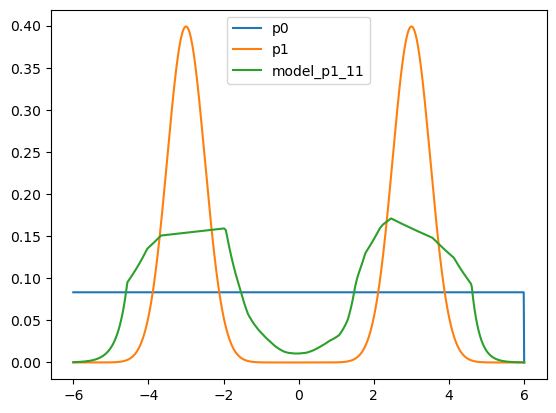

T:  10
Time:  11 iteration:  0 loss:  3.5608763694763184 acc:  0.5 kl_div:  tensor(-9.3032, device='cuda:0') mse:  tensor(1.2132, device='cuda:0') js_div:  [0.00048433]
Time:  11 iteration:  100 loss:  2.235732078552246 acc:  0.48455 kl_div:  tensor(23280.0664, device='cuda:0') mse:  tensor(0.9074, device='cuda:0') js_div:  [0.03992023]
Time:  11 iteration:  200 loss:  2.1708993911743164 acc:  0.48585 kl_div:  tensor(73.8469, device='cuda:0') mse:  tensor(0.0008, device='cuda:0') js_div:  [0.00270321]
Time:  11 iteration:  300 loss:  2.1298880577087402 acc:  0.4793 kl_div:  tensor(139.0434, device='cuda:0') mse:  tensor(0.0008, device='cuda:0') js_div:  [0.00251401]
Time:  11 iteration:  400 loss:  2.0986859798431396 acc:  0.4785 kl_div:  tensor(89.3554, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00223195]
Time:  11 iteration:  500 loss:  2.0777711868286133 acc:  0.4768 kl_div:  tensor(40.1802, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.0

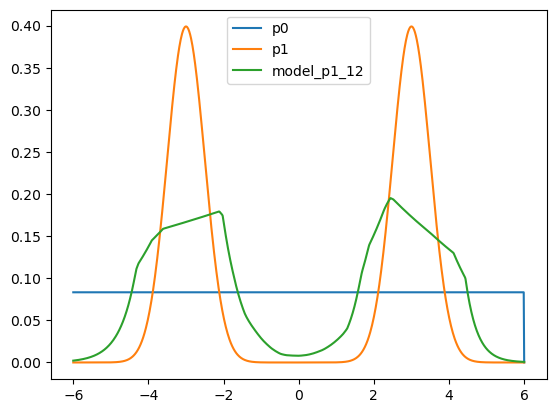

T:  11
Time:  12 iteration:  0 loss:  3.3704848289489746 acc:  0.5 kl_div:  tensor(-9.2269, device='cuda:0') mse:  tensor(1.0752, device='cuda:0') js_div:  [0.00249264]
Time:  12 iteration:  100 loss:  2.2262368202209473 acc:  0.483 kl_div:  tensor(19925.1895, device='cuda:0') mse:  tensor(0.7636, device='cuda:0') js_div:  [0.0311907]
Time:  12 iteration:  200 loss:  2.1697826385498047 acc:  0.47795 kl_div:  tensor(147.7817, device='cuda:0') mse:  tensor(0.0011, device='cuda:0') js_div:  [0.00260526]
Time:  12 iteration:  300 loss:  2.1273372173309326 acc:  0.47995 kl_div:  tensor(123.5868, device='cuda:0') mse:  tensor(0.0008, device='cuda:0') js_div:  [0.00265544]
Time:  12 iteration:  400 loss:  2.0835368633270264 acc:  0.47595 kl_div:  tensor(68.2609, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.00190606]
Time:  12 iteration:  500 loss:  2.0625174045562744 acc:  0.47635 kl_div:  tensor(29.0139, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0

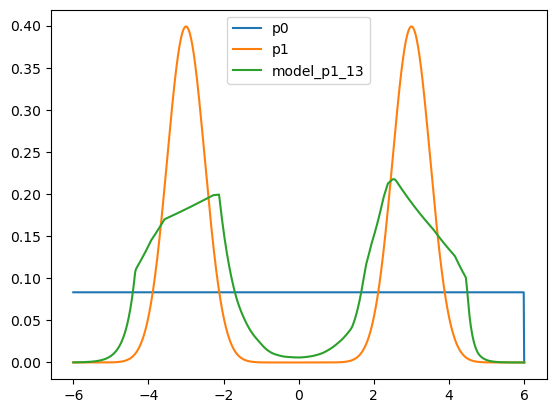

T:  12
Time:  13 iteration:  0 loss:  3.3209569454193115 acc:  0.5 kl_div:  tensor(-9.2247, device='cuda:0') mse:  tensor(1.2260, device='cuda:0') js_div:  [0.01106109]
Time:  13 iteration:  100 loss:  2.2106735706329346 acc:  0.4767 kl_div:  tensor(21228.4727, device='cuda:0') mse:  tensor(0.9109, device='cuda:0') js_div:  [0.03660092]
Time:  13 iteration:  200 loss:  2.146869659423828 acc:  0.47415 kl_div:  tensor(115.1250, device='cuda:0') mse:  tensor(0.0011, device='cuda:0') js_div:  [0.00328931]
Time:  13 iteration:  300 loss:  2.1106371879577637 acc:  0.47505 kl_div:  tensor(96.2942, device='cuda:0') mse:  tensor(0.0006, device='cuda:0') js_div:  [0.0023854]
Time:  13 iteration:  400 loss:  2.0895543098449707 acc:  0.4767 kl_div:  tensor(39.6440, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00132482]
Time:  13 iteration:  500 loss:  2.069094657897949 acc:  0.47925 kl_div:  tensor(10.9309, device='cuda:0') mse:  tensor(6.8040e-05, device='cuda:0') js_div:  [

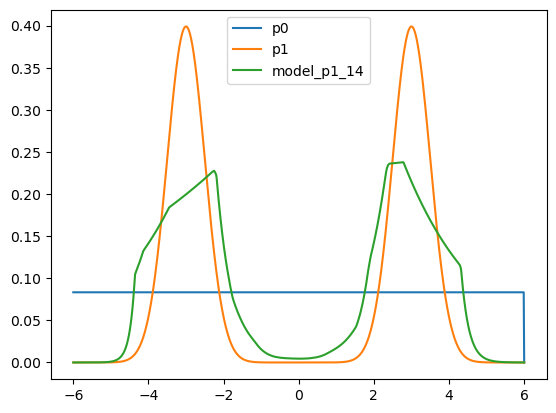

T:  13
Time:  14 iteration:  0 loss:  3.008829355239868 acc:  0.5 kl_div:  tensor(-9.0000, device='cuda:0') mse:  tensor(0.7100, device='cuda:0') js_div:  [0.00497245]
Time:  14 iteration:  100 loss:  2.210667610168457 acc:  0.47315 kl_div:  tensor(13256.1143, device='cuda:0') mse:  tensor(0.4482, device='cuda:0') js_div:  [0.01524398]
Time:  14 iteration:  200 loss:  2.1519062519073486 acc:  0.4752 kl_div:  tensor(139.7691, device='cuda:0') mse:  tensor(0.0008, device='cuda:0') js_div:  [0.00188798]
Time:  14 iteration:  300 loss:  2.1222896575927734 acc:  0.4756 kl_div:  tensor(64.2038, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.00155658]
Time:  14 iteration:  400 loss:  2.1001737117767334 acc:  0.47565 kl_div:  tensor(34.4545, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00112205]
Time:  14 iteration:  500 loss:  2.07871675491333 acc:  0.47825 kl_div:  tensor(7.8913, device='cuda:0') mse:  tensor(8.3382e-05, device='cuda:0') js_div:  [0.

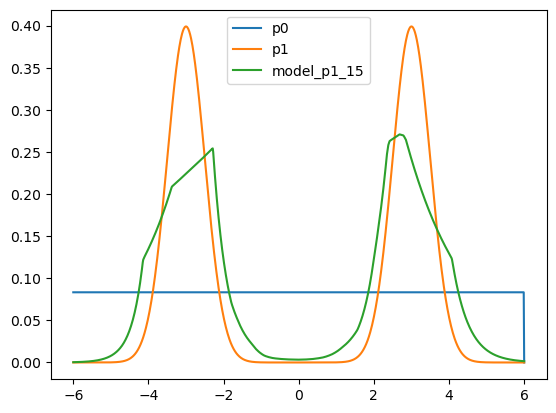

T:  14
Time:  15 iteration:  0 loss:  3.6728410720825195 acc:  0.5 kl_div:  tensor(-9.6219, device='cuda:0') mse:  tensor(2.4047, device='cuda:0') js_div:  [0.00335021]
Time:  15 iteration:  100 loss:  2.2158169746398926 acc:  0.47305 kl_div:  tensor(34661.8555, device='cuda:0') mse:  tensor(1.9349, device='cuda:0') js_div:  [0.0238669]
Time:  15 iteration:  200 loss:  2.174994945526123 acc:  0.4724 kl_div:  tensor(9.3965, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.00125502]
Time:  15 iteration:  300 loss:  2.1489310264587402 acc:  0.47165 kl_div:  tensor(41.7560, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00092635]
Time:  15 iteration:  400 loss:  2.1267523765563965 acc:  0.47495 kl_div:  tensor(38.1394, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00090355]
Time:  15 iteration:  500 loss:  2.105424404144287 acc:  0.4736 kl_div:  tensor(12.5483, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.0006

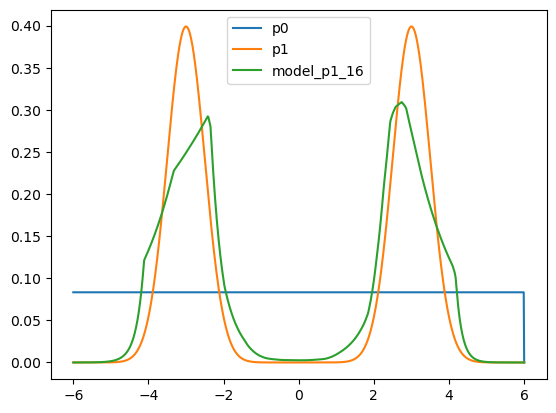

T:  15
Time:  16 iteration:  0 loss:  3.490631580352783 acc:  0.5 kl_div:  tensor(-9.5372, device='cuda:0') mse:  tensor(2.3300, device='cuda:0') js_div:  [0.01214559]
Time:  16 iteration:  100 loss:  2.2494750022888184 acc:  0.4725 kl_div:  tensor(30692.4199, device='cuda:0') mse:  tensor(1.8122, device='cuda:0') js_div:  [0.02981165]
Time:  16 iteration:  200 loss:  2.2218387126922607 acc:  0.47175 kl_div:  tensor(81.3737, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00088196]
Time:  16 iteration:  300 loss:  2.176422119140625 acc:  0.47275 kl_div:  tensor(52.6662, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.00098524]
Time:  16 iteration:  400 loss:  2.1597771644592285 acc:  0.4735 kl_div:  tensor(50.9962, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00101049]
Time:  16 iteration:  500 loss:  2.136183261871338 acc:  0.4761 kl_div:  tensor(17.2766, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.0007

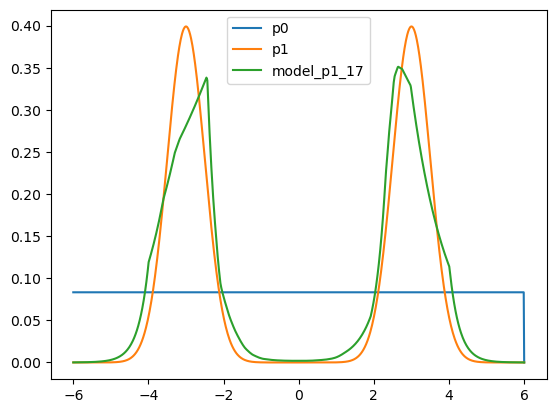

T:  16
Time:  17 iteration:  0 loss:  3.383012056350708 acc:  0.5 kl_div:  tensor(-9.5693, device='cuda:0') mse:  tensor(2.0945, device='cuda:0') js_div:  [0.00134091]
Time:  17 iteration:  100 loss:  2.241488218307495 acc:  0.4713 kl_div:  tensor(29052.6484, device='cuda:0') mse:  tensor(1.5659, device='cuda:0') js_div:  [0.01383704]
Time:  17 iteration:  200 loss:  2.1992177963256836 acc:  0.46985 kl_div:  tensor(-58.5019, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.00105001]
Time:  17 iteration:  300 loss:  2.168968915939331 acc:  0.47105 kl_div:  tensor(31.1703, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00078515]
Time:  17 iteration:  400 loss:  2.155669689178467 acc:  0.4715 kl_div:  tensor(20.3291, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00072021]
Time:  17 iteration:  500 loss:  2.130366325378418 acc:  0.47345 kl_div:  tensor(3.3880, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00053

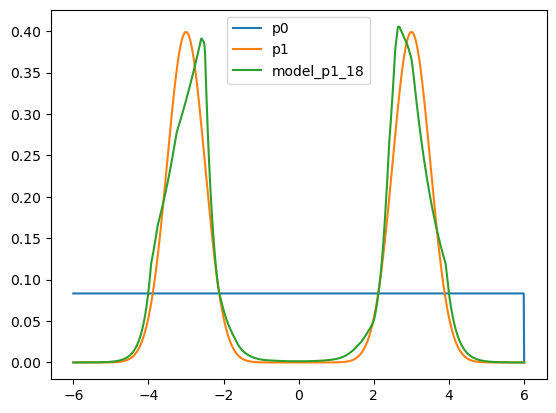

T:  17
Time:  18 iteration:  0 loss:  2.845848798751831 acc:  0.5 kl_div:  tensor(-9.1513, device='cuda:0') mse:  tensor(0.9130, device='cuda:0') js_div:  [0.0017164]
Time:  18 iteration:  100 loss:  2.246281147003174 acc:  0.4679 kl_div:  tensor(13569.7188, device='cuda:0') mse:  tensor(0.5272, device='cuda:0') js_div:  [0.00658089]
Time:  18 iteration:  200 loss:  2.202913761138916 acc:  0.46755 kl_div:  tensor(44.0301, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00036497]
Time:  18 iteration:  300 loss:  2.20428466796875 acc:  0.47045 kl_div:  tensor(22.4313, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00050582]
Time:  18 iteration:  400 loss:  2.1747078895568848 acc:  0.47075 kl_div:  tensor(13.9960, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00060069]
Time:  18 iteration:  500 loss:  2.1451189517974854 acc:  0.4711 kl_div:  tensor(5.4346, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.0004860

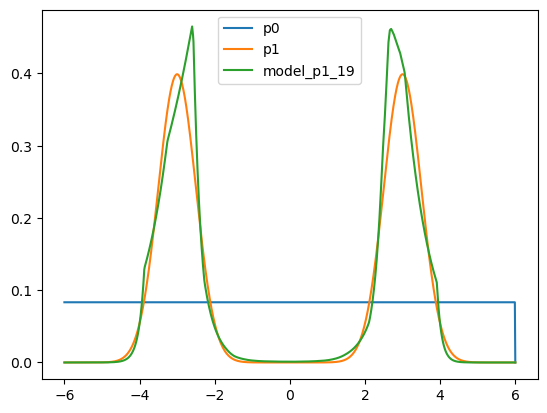

T:  18
Time:  19 iteration:  0 loss:  2.8003299236297607 acc:  0.5 kl_div:  tensor(-9.1837, device='cuda:0') mse:  tensor(0.9485, device='cuda:0') js_div:  [3.1282118e-05]
Time:  19 iteration:  100 loss:  2.2228708267211914 acc:  0.49515 kl_div:  tensor(13462.3672, device='cuda:0') mse:  tensor(0.5274, device='cuda:0') js_div:  [0.00474931]
Time:  19 iteration:  200 loss:  2.193995475769043 acc:  0.4958 kl_div:  tensor(41.0050, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00028704]
Time:  19 iteration:  300 loss:  2.1812326908111572 acc:  0.4925 kl_div:  tensor(22.8669, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.0003985]
Time:  19 iteration:  400 loss:  2.1445114612579346 acc:  0.50095 kl_div:  tensor(24.3523, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00049485]
Time:  19 iteration:  500 loss:  2.1485252380371094 acc:  0.50265 kl_div:  tensor(1.3289, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.

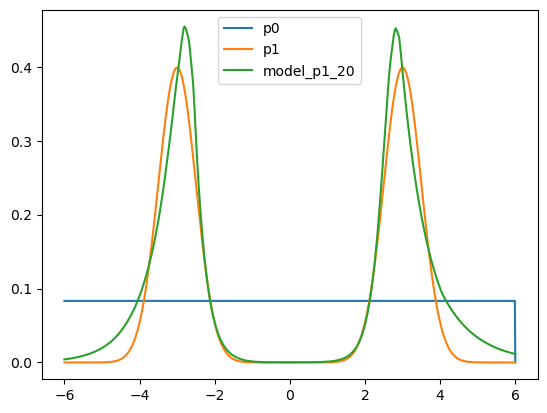

T:  19


In [25]:
model = train(u,30000,lr=1e-4,exponential=True)

## NCE with exponential loss and NGD

Time:  0 iteration:  0 loss:  4.041319370269775 acc:  0.5 kl_div:  tensor(-9.3494, device='cuda:0') mse:  tensor(1.3605, device='cuda:0') js_div:  [0.00183885]
Time:  0 iteration:  100 loss:  2.2338128089904785 acc:  0.50335 kl_div:  tensor(25988.0371, device='cuda:0') mse:  tensor(1.0181, device='cuda:0') js_div:  [0.07977229]
Time:  0 iteration:  200 loss:  2.0487656593322754 acc:  0.50285 kl_div:  tensor(972.0273, device='cuda:0') mse:  tensor(0.0130, device='cuda:0') js_div:  [0.01839038]
Time:  0 iteration:  300 loss:  1.9990394115447998 acc:  0.51 kl_div:  tensor(388.7267, device='cuda:0') mse:  tensor(0.0025, device='cuda:0') js_div:  [0.01867134]
Time:  0 iteration:  400 loss:  1.9988594055175781 acc:  0.51055 kl_div:  tensor(-1.2006, device='cuda:0') mse:  tensor(1.2620e-06, device='cuda:0') js_div:  [2.2290496e-05]
Time:  0 iteration:  500 loss:  1.9988117218017578 acc:  0.51175 kl_div:  tensor(1.3828, device='cuda:0') mse:  tensor(2.1775e-07, device='cuda:0') js_div:  [3.703

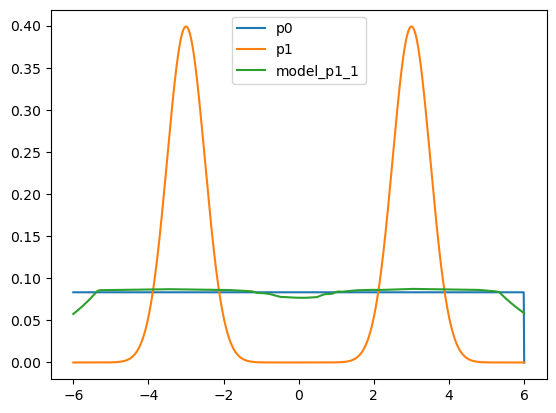

T:  0
Time:  1 iteration:  0 loss:  3.4446427822113037 acc:  0.5 kl_div:  tensor(-8.9828, device='cuda:0') mse:  tensor(0.6358, device='cuda:0') js_div:  [0.00015325]
Time:  1 iteration:  100 loss:  2.1707558631896973 acc:  0.5025 kl_div:  tensor(15355.8379, device='cuda:0') mse:  tensor(0.4294, device='cuda:0') js_div:  [0.05483268]
Time:  1 iteration:  200 loss:  2.031193256378174 acc:  0.5026 kl_div:  tensor(677.5837, device='cuda:0') mse:  tensor(0.0072, device='cuda:0') js_div:  [0.0188946]
Time:  1 iteration:  300 loss:  2.001333475112915 acc:  0.50115 kl_div:  tensor(230.0421, device='cuda:0') mse:  tensor(0.0012, device='cuda:0') js_div:  [0.01088122]
Time:  1 iteration:  400 loss:  2.000901699066162 acc:  0.501 kl_div:  tensor(0.3238, device='cuda:0') mse:  tensor(1.5900e-06, device='cuda:0') js_div:  [2.782794e-05]
Time:  1 iteration:  500 loss:  2.0008456707000732 acc:  0.50165 kl_div:  tensor(0.0172, device='cuda:0') mse:  tensor(4.3404e-07, device='cuda:0') js_div:  [8.282

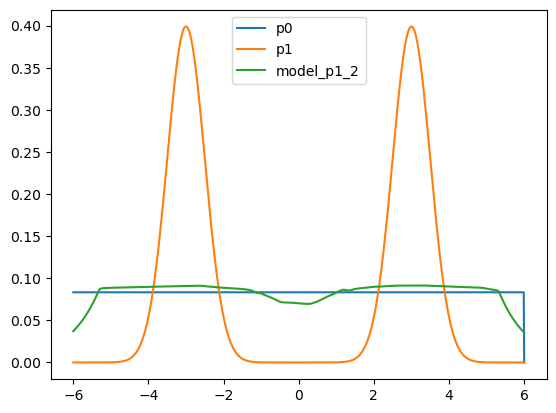

T:  1
Time:  2 iteration:  0 loss:  3.461433172225952 acc:  0.5 kl_div:  tensor(-8.9785, device='cuda:0') mse:  tensor(0.7280, device='cuda:0') js_div:  [0.00943842]
Time:  2 iteration:  100 loss:  2.2124640941619873 acc:  0.50315 kl_div:  tensor(15433.4648, device='cuda:0') mse:  tensor(0.4876, device='cuda:0') js_div:  [0.06042831]
Time:  2 iteration:  200 loss:  2.054819345474243 acc:  0.49745 kl_div:  tensor(873.3707, device='cuda:0') mse:  tensor(0.0106, device='cuda:0') js_div:  [0.0167461]
Time:  2 iteration:  300 loss:  2.0047430992126465 acc:  0.49685 kl_div:  tensor(339.9424, device='cuda:0') mse:  tensor(0.0023, device='cuda:0') js_div:  [0.01784851]
Time:  2 iteration:  400 loss:  2.003326416015625 acc:  0.50245 kl_div:  tensor(-0.8738, device='cuda:0') mse:  tensor(1.4756e-05, device='cuda:0') js_div:  [0.0002537]
Time:  2 iteration:  500 loss:  2.002847909927368 acc:  0.50355 kl_div:  tensor(-0.9022, device='cuda:0') mse:  tensor(6.3059e-07, device='cuda:0') js_div:  [1.0

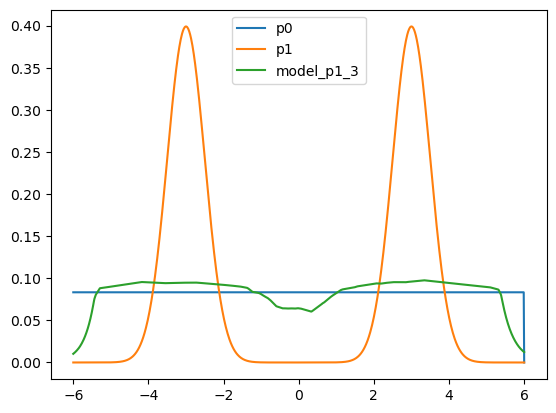

T:  2
Time:  3 iteration:  0 loss:  3.687664031982422 acc:  0.5 kl_div:  tensor(-9.1736, device='cuda:0') mse:  tensor(0.9399, device='cuda:0') js_div:  [0.00073403]
Time:  3 iteration:  100 loss:  2.1834912300109863 acc:  0.50125 kl_div:  tensor(20243.8398, device='cuda:0') mse:  tensor(0.6795, device='cuda:0') js_div:  [0.04958277]
Time:  3 iteration:  200 loss:  2.0177550315856934 acc:  0.49055 kl_div:  tensor(956.2158, device='cuda:0') mse:  tensor(0.0114, device='cuda:0') js_div:  [0.04102712]
Time:  3 iteration:  300 loss:  2.0071263313293457 acc:  0.5011 kl_div:  tensor(59.2538, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00292684]
Time:  3 iteration:  400 loss:  2.007277250289917 acc:  0.5027 kl_div:  tensor(-9.1987, device='cuda:0') mse:  tensor(3.7121e-06, device='cuda:0') js_div:  [5.0110073e-05]
Time:  3 iteration:  500 loss:  2.0063490867614746 acc:  0.5041 kl_div:  tensor(2.7287, device='cuda:0') mse:  tensor(8.7715e-07, device='cuda:0') js_div:  [1

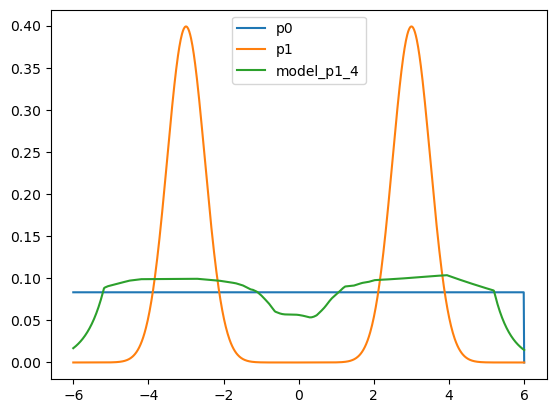

T:  3
Time:  4 iteration:  0 loss:  3.930328369140625 acc:  0.5 kl_div:  tensor(-9.3139, device='cuda:0') mse:  tensor(1.3540, device='cuda:0') js_div:  [0.00595775]
Time:  4 iteration:  100 loss:  2.1967194080352783 acc:  0.502 kl_div:  tensor(26202.3242, device='cuda:0') mse:  tensor(1.0545, device='cuda:0') js_div:  [0.070494]
Time:  4 iteration:  200 loss:  2.039257526397705 acc:  0.49165 kl_div:  tensor(886.8547, device='cuda:0') mse:  tensor(0.0111, device='cuda:0') js_div:  [0.02747785]
Time:  4 iteration:  300 loss:  2.008869171142578 acc:  0.49195 kl_div:  tensor(162.8795, device='cuda:0') mse:  tensor(0.0009, device='cuda:0') js_div:  [0.00981512]
Time:  4 iteration:  400 loss:  2.0060503482818604 acc:  0.5022 kl_div:  tensor(-8.6068, device='cuda:0') mse:  tensor(1.5280e-05, device='cuda:0') js_div:  [0.00024202]
Time:  4 iteration:  500 loss:  2.005216121673584 acc:  0.5034 kl_div:  tensor(1.6593, device='cuda:0') mse:  tensor(2.3258e-06, device='cuda:0') js_div:  [4.143078

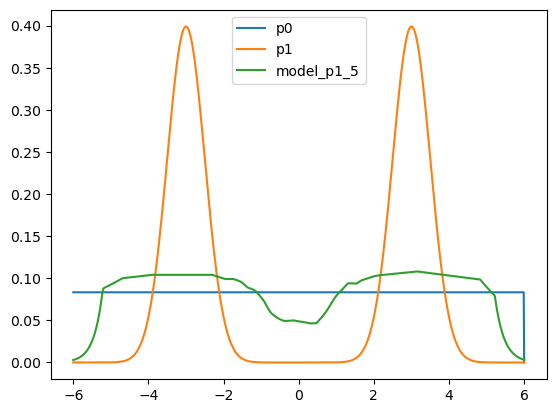

T:  4
Time:  5 iteration:  0 loss:  3.714068651199341 acc:  0.5 kl_div:  tensor(-9.2019, device='cuda:0') mse:  tensor(1.0932, device='cuda:0') js_div:  [0.00678031]
Time:  5 iteration:  100 loss:  2.2475714683532715 acc:  0.49995 kl_div:  tensor(20909.2793, device='cuda:0') mse:  tensor(0.7766, device='cuda:0') js_div:  [0.06212689]
Time:  5 iteration:  200 loss:  2.0697526931762695 acc:  0.49195 kl_div:  tensor(852.4618, device='cuda:0') mse:  tensor(0.0116, device='cuda:0') js_div:  [0.02063814]
Time:  5 iteration:  300 loss:  2.015197992324829 acc:  0.4881 kl_div:  tensor(303.3806, device='cuda:0') mse:  tensor(0.0021, device='cuda:0') js_div:  [0.01768387]
Time:  5 iteration:  400 loss:  2.010599374771118 acc:  0.50025 kl_div:  tensor(-12.6869, device='cuda:0') mse:  tensor(5.1407e-05, device='cuda:0') js_div:  [0.00080437]
Time:  5 iteration:  500 loss:  2.0088772773742676 acc:  0.5043 kl_div:  tensor(4.3960, device='cuda:0') mse:  tensor(5.1785e-06, device='cuda:0') js_div:  [8.

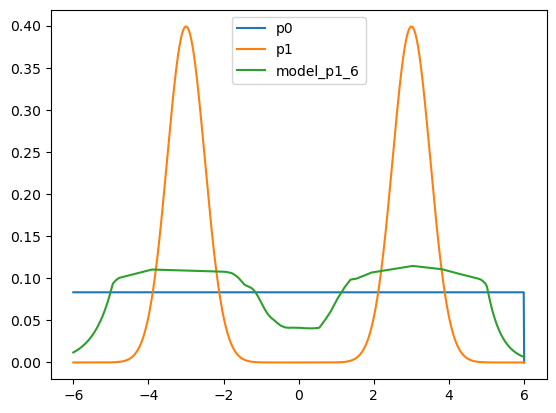

T:  5
Time:  6 iteration:  0 loss:  3.362396478652954 acc:  0.5 kl_div:  tensor(-9.0029, device='cuda:0') mse:  tensor(0.6659, device='cuda:0') js_div:  [0.00053038]
Time:  6 iteration:  100 loss:  2.1663384437561035 acc:  0.49575 kl_div:  tensor(14885.0303, device='cuda:0') mse:  tensor(0.4454, device='cuda:0') js_div:  [0.02914334]
Time:  6 iteration:  200 loss:  2.0330393314361572 acc:  0.48735 kl_div:  tensor(712.6498, device='cuda:0') mse:  tensor(0.0079, device='cuda:0') js_div:  [0.02939622]
Time:  6 iteration:  300 loss:  2.009950876235962 acc:  0.4932 kl_div:  tensor(77.0836, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.00553331]
Time:  6 iteration:  400 loss:  2.0074210166931152 acc:  0.50535 kl_div:  tensor(-10.2587, device='cuda:0') mse:  tensor(1.8448e-05, device='cuda:0') js_div:  [0.00027609]
Time:  6 iteration:  500 loss:  2.006636142730713 acc:  0.5045 kl_div:  tensor(-9.6440, device='cuda:0') mse:  tensor(4.6165e-06, device='cuda:0') js_div:  [5.

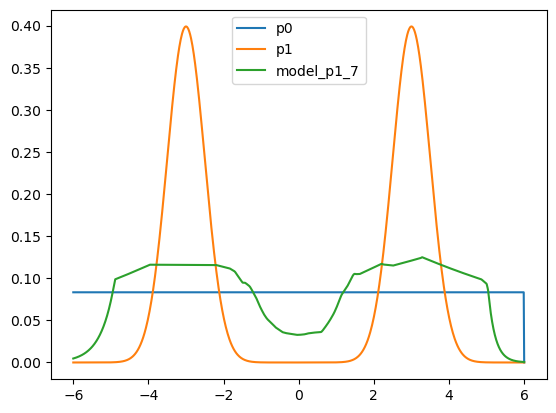

T:  6
Time:  7 iteration:  0 loss:  4.041407108306885 acc:  0.5 kl_div:  tensor(-9.4676, device='cuda:0') mse:  tensor(1.7402, device='cuda:0') js_div:  [0.00245172]
Time:  7 iteration:  100 loss:  2.2501487731933594 acc:  0.4971 kl_div:  tensor(31183.8457, device='cuda:0') mse:  tensor(1.3737, device='cuda:0') js_div:  [0.07625617]
Time:  7 iteration:  200 loss:  2.1097915172576904 acc:  0.49055 kl_div:  tensor(516.2134, device='cuda:0') mse:  tensor(0.0063, device='cuda:0') js_div:  [0.01168519]
Time:  7 iteration:  300 loss:  2.0340964794158936 acc:  0.4809 kl_div:  tensor(337.0317, device='cuda:0') mse:  tensor(0.0028, device='cuda:0') js_div:  [0.01689359]
Time:  7 iteration:  400 loss:  2.0172581672668457 acc:  0.4837 kl_div:  tensor(48.0628, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00250884]
Time:  7 iteration:  500 loss:  2.0127248764038086 acc:  0.4955 kl_div:  tensor(-19.2100, device='cuda:0') mse:  tensor(4.2139e-05, device='cuda:0') js_div:  [0.000

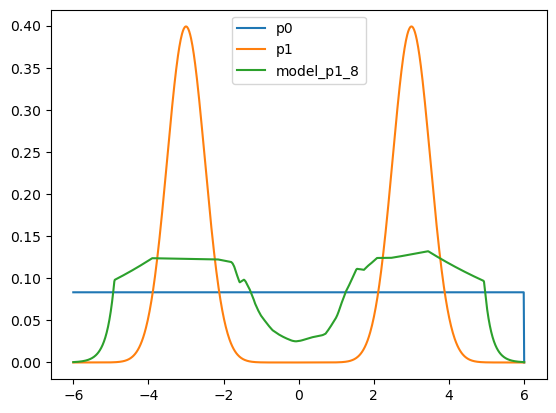

T:  7
Time:  8 iteration:  0 loss:  3.546618938446045 acc:  0.5 kl_div:  tensor(-9.1971, device='cuda:0') mse:  tensor(0.9800, device='cuda:0') js_div:  [0.00040326]
Time:  8 iteration:  100 loss:  2.175630569458008 acc:  0.4892 kl_div:  tensor(20666.6543, device='cuda:0') mse:  tensor(0.7289, device='cuda:0') js_div:  [0.03935146]
Time:  8 iteration:  200 loss:  2.057589292526245 acc:  0.4839 kl_div:  tensor(470.8489, device='cuda:0') mse:  tensor(0.0050, device='cuda:0') js_div:  [0.02066344]
Time:  8 iteration:  300 loss:  2.0280680656433105 acc:  0.4828 kl_div:  tensor(124.8470, device='cuda:0') mse:  tensor(0.0007, device='cuda:0') js_div:  [0.00711218]
Time:  8 iteration:  400 loss:  2.0168752670288086 acc:  0.48715 kl_div:  tensor(-29.3626, device='cuda:0') mse:  tensor(7.5322e-05, device='cuda:0') js_div:  [0.00081127]
Time:  8 iteration:  500 loss:  2.0130815505981445 acc:  0.4993 kl_div:  tensor(-14.4036, device='cuda:0') mse:  tensor(4.2510e-05, device='cuda:0') js_div:  [0.

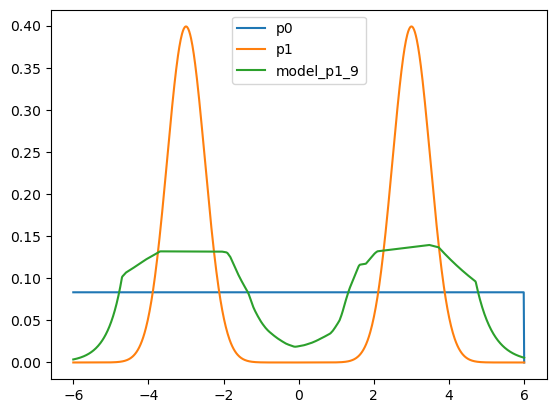

T:  8
Time:  9 iteration:  0 loss:  3.31902813911438 acc:  0.5 kl_div:  tensor(-9.0419, device='cuda:0') mse:  tensor(0.8291, device='cuda:0') js_div:  [0.00942464]
Time:  9 iteration:  100 loss:  2.2160654067993164 acc:  0.49255 kl_div:  tensor(17067.8359, device='cuda:0') mse:  tensor(0.5920, device='cuda:0') js_div:  [0.05113075]
Time:  9 iteration:  200 loss:  2.0891213417053223 acc:  0.48335 kl_div:  tensor(485.3652, device='cuda:0') mse:  tensor(0.0057, device='cuda:0') js_div:  [0.01668138]
Time:  9 iteration:  300 loss:  2.0366175174713135 acc:  0.4815 kl_div:  tensor(195.2975, device='cuda:0') mse:  tensor(0.0014, device='cuda:0') js_div:  [0.01055857]
Time:  9 iteration:  400 loss:  2.01753568649292 acc:  0.4878 kl_div:  tensor(-9.5179, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00164194]
Time:  9 iteration:  500 loss:  2.010188102722168 acc:  0.4968 kl_div:  tensor(-35.0196, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00089251]


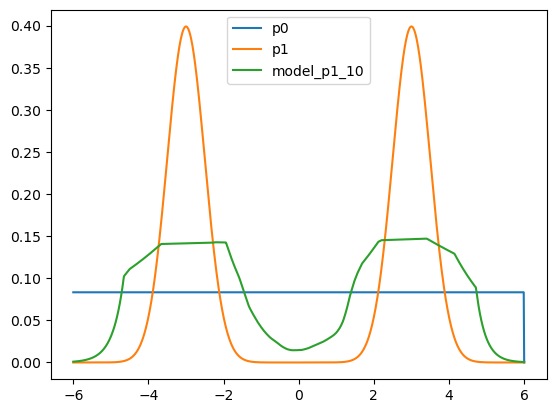

T:  9
Time:  10 iteration:  0 loss:  3.142993688583374 acc:  0.5 kl_div:  tensor(-8.9393, device='cuda:0') mse:  tensor(0.5937, device='cuda:0') js_div:  [0.00133136]
Time:  10 iteration:  100 loss:  2.1637651920318604 acc:  0.4879 kl_div:  tensor(13205.0762, device='cuda:0') mse:  tensor(0.3904, device='cuda:0') js_div:  [0.01538271]
Time:  10 iteration:  200 loss:  2.0564932823181152 acc:  0.4793 kl_div:  tensor(402.8876, device='cuda:0') mse:  tensor(0.0041, device='cuda:0') js_div:  [0.01967324]
Time:  10 iteration:  300 loss:  2.028215169906616 acc:  0.48145 kl_div:  tensor(22.9645, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00297049]
Time:  10 iteration:  400 loss:  2.0142922401428223 acc:  0.49115 kl_div:  tensor(-25.5720, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00112008]
Time:  10 iteration:  500 loss:  2.010331630706787 acc:  0.50195 kl_div:  tensor(-38.0023, device='cuda:0') mse:  tensor(7.8118e-05, device='cuda:0') js_div:  

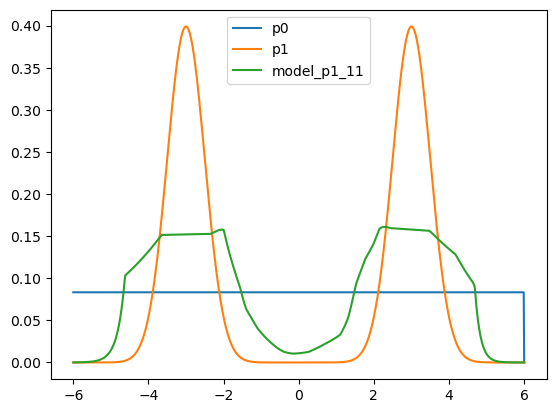

T:  10
Time:  11 iteration:  0 loss:  2.951967477798462 acc:  0.5 kl_div:  tensor(-8.8142, device='cuda:0') mse:  tensor(0.4630, device='cuda:0') js_div:  [0.00141684]
Time:  11 iteration:  100 loss:  2.1805386543273926 acc:  0.4866 kl_div:  tensor(10420.7988, device='cuda:0') mse:  tensor(0.2762, device='cuda:0') js_div:  [0.01351566]
Time:  11 iteration:  200 loss:  2.0823817253112793 acc:  0.47675 kl_div:  tensor(350.1060, device='cuda:0') mse:  tensor(0.0038, device='cuda:0') js_div:  [0.0148445]
Time:  11 iteration:  300 loss:  2.0463616847991943 acc:  0.479 kl_div:  tensor(87.7971, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00490621]
Time:  11 iteration:  400 loss:  2.0281002521514893 acc:  0.4815 kl_div:  tensor(-18.7013, device='cuda:0') mse:  tensor(7.5469e-05, device='cuda:0') js_div:  [0.00075253]
Time:  11 iteration:  500 loss:  2.0172812938690186 acc:  0.49375 kl_div:  tensor(-41.3865, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  

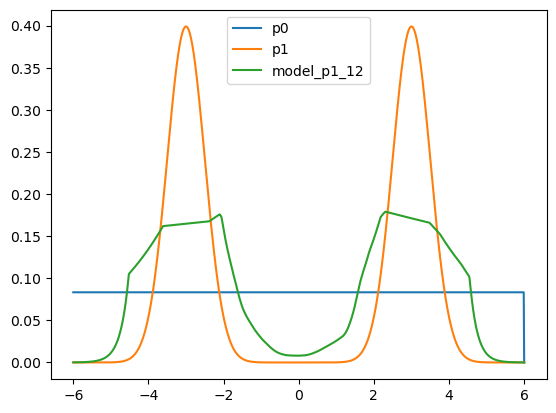

T:  11
Time:  12 iteration:  0 loss:  3.6428322792053223 acc:  0.5 kl_div:  tensor(-9.4117, device='cuda:0') mse:  tensor(1.5248, device='cuda:0') js_div:  [0.00119168]
Time:  12 iteration:  100 loss:  2.2001819610595703 acc:  0.48355 kl_div:  tensor(26432.9648, device='cuda:0') mse:  tensor(1.1667, device='cuda:0') js_div:  [0.02769988]
Time:  12 iteration:  200 loss:  2.1045565605163574 acc:  0.4767 kl_div:  tensor(281.3859, device='cuda:0') mse:  tensor(0.0034, device='cuda:0') js_div:  [0.01179335]
Time:  12 iteration:  300 loss:  2.061478853225708 acc:  0.4797 kl_div:  tensor(116.6564, device='cuda:0') mse:  tensor(0.0009, device='cuda:0') js_div:  [0.00641616]
Time:  12 iteration:  400 loss:  2.0424675941467285 acc:  0.4773 kl_div:  tensor(-10.2742, device='cuda:0') mse:  tensor(4.4335e-05, device='cuda:0') js_div:  [0.0005158]
Time:  12 iteration:  500 loss:  2.0300464630126953 acc:  0.48 kl_div:  tensor(-15.5322, device='cuda:0') mse:  tensor(6.1828e-05, device='cuda:0') js_div

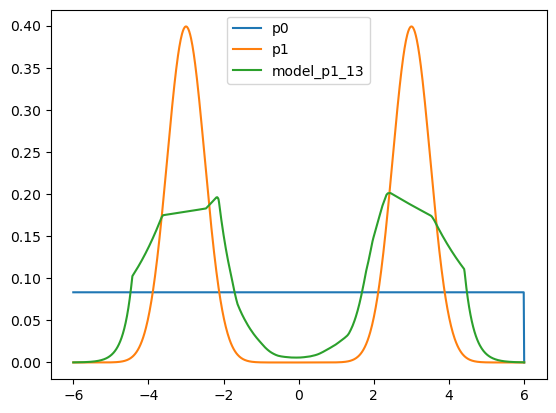

T:  12
Time:  13 iteration:  0 loss:  2.848865270614624 acc:  0.5 kl_div:  tensor(-8.7856, device='cuda:0') mse:  tensor(0.4708, device='cuda:0') js_div:  [0.00613811]
Time:  13 iteration:  100 loss:  2.183720350265503 acc:  0.4812 kl_div:  tensor(9614.3613, device='cuda:0') mse:  tensor(0.2677, device='cuda:0') js_div:  [0.01048374]
Time:  13 iteration:  200 loss:  2.1055684089660645 acc:  0.4752 kl_div:  tensor(255.5473, device='cuda:0') mse:  tensor(0.0026, device='cuda:0') js_div:  [0.00926398]
Time:  13 iteration:  300 loss:  2.0672435760498047 acc:  0.4789 kl_div:  tensor(88.2168, device='cuda:0') mse:  tensor(0.0007, device='cuda:0') js_div:  [0.0041631]
Time:  13 iteration:  400 loss:  2.0445914268493652 acc:  0.4788 kl_div:  tensor(-15.4768, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00090193]
Time:  13 iteration:  500 loss:  2.0296154022216797 acc:  0.47875 kl_div:  tensor(-28.9497, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.000

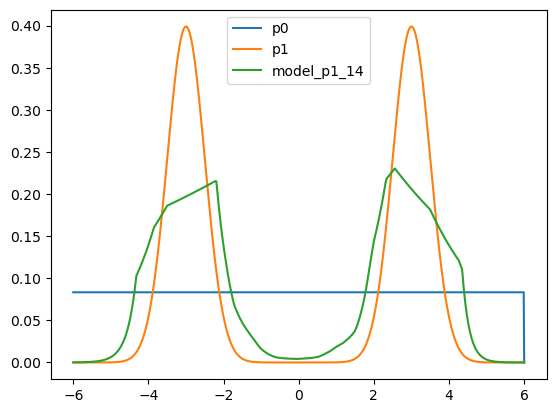

T:  13
Time:  14 iteration:  0 loss:  3.180765390396118 acc:  0.5 kl_div:  tensor(-9.1747, device='cuda:0') mse:  tensor(0.9516, device='cuda:0') js_div:  [0.00137716]
Time:  14 iteration:  100 loss:  2.2243285179138184 acc:  0.47795 kl_div:  tensor(17158.8320, device='cuda:0') mse:  tensor(0.6412, device='cuda:0') js_div:  [0.01770724]
Time:  14 iteration:  200 loss:  2.1242175102233887 acc:  0.4757 kl_div:  tensor(220.1597, device='cuda:0') mse:  tensor(0.0029, device='cuda:0') js_div:  [0.00856604]
Time:  14 iteration:  300 loss:  2.082059383392334 acc:  0.4744 kl_div:  tensor(99.6402, device='cuda:0') mse:  tensor(0.0010, device='cuda:0') js_div:  [0.00513262]
Time:  14 iteration:  400 loss:  2.054074287414551 acc:  0.47875 kl_div:  tensor(-2.2909, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00108538]
Time:  14 iteration:  500 loss:  2.0338118076324463 acc:  0.47885 kl_div:  tensor(-28.5115, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.0

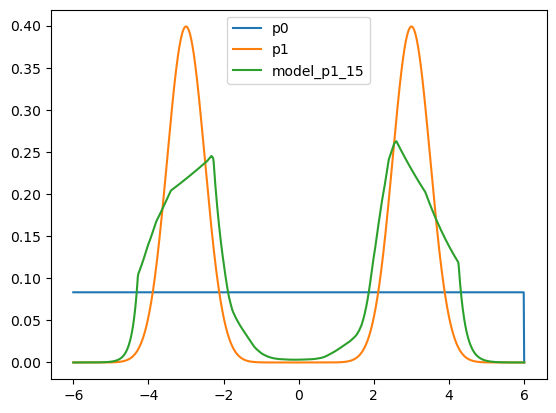

T:  14
Time:  15 iteration:  0 loss:  2.906614065170288 acc:  0.5 kl_div:  tensor(-8.9708, device='cuda:0') mse:  tensor(0.6233, device='cuda:0') js_div:  [0.00041132]
Time:  15 iteration:  100 loss:  2.1962671279907227 acc:  0.47045 kl_div:  tensor(11861.3027, device='cuda:0') mse:  tensor(0.3727, device='cuda:0') js_div:  [0.00421462]
Time:  15 iteration:  200 loss:  2.123277425765991 acc:  0.4746 kl_div:  tensor(132.7664, device='cuda:0') mse:  tensor(0.0021, device='cuda:0') js_div:  [0.00767291]
Time:  15 iteration:  300 loss:  2.090283155441284 acc:  0.47585 kl_div:  tensor(50.4816, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.00235623]
Time:  15 iteration:  400 loss:  2.068246841430664 acc:  0.477 kl_div:  tensor(-32.9358, device='cuda:0') mse:  tensor(6.0588e-05, device='cuda:0') js_div:  [0.00029291]
Time:  15 iteration:  500 loss:  2.0509934425354004 acc:  0.4794 kl_div:  tensor(-31.3105, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0

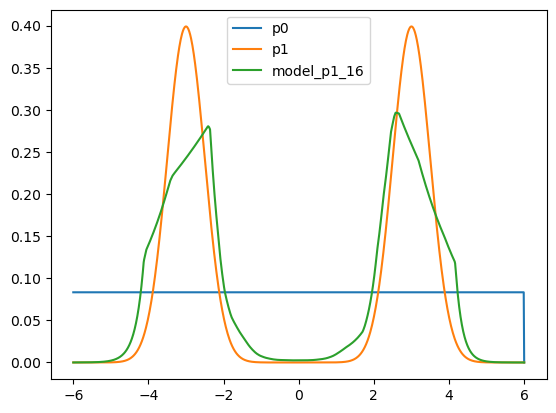

T:  15
Time:  16 iteration:  0 loss:  2.751232147216797 acc:  0.5 kl_div:  tensor(-8.8882, device='cuda:0') mse:  tensor(0.5324, device='cuda:0') js_div:  [0.00089758]
Time:  16 iteration:  100 loss:  2.226423978805542 acc:  0.47065 kl_div:  tensor(9525.3164, device='cuda:0') mse:  tensor(0.2788, device='cuda:0') js_div:  [0.00500159]
Time:  16 iteration:  200 loss:  2.1534345149993896 acc:  0.47095 kl_div:  tensor(170.8118, device='cuda:0') mse:  tensor(0.0020, device='cuda:0') js_div:  [0.00466216]
Time:  16 iteration:  300 loss:  2.1026525497436523 acc:  0.47445 kl_div:  tensor(45.7124, device='cuda:0') mse:  tensor(0.0008, device='cuda:0') js_div:  [0.00294514]
Time:  16 iteration:  400 loss:  2.0827255249023438 acc:  0.4765 kl_div:  tensor(16.8377, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00066268]
Time:  16 iteration:  500 loss:  2.0597267150878906 acc:  0.4766 kl_div:  tensor(-33.3454, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.0

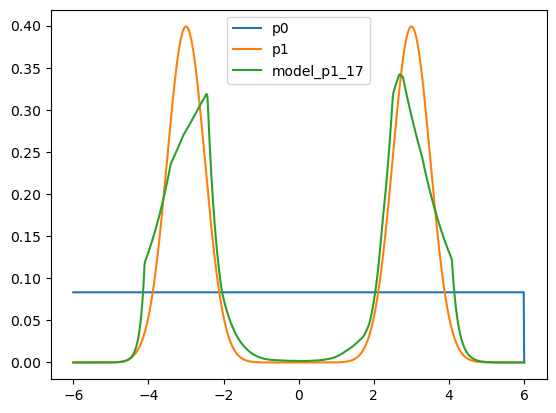

T:  16
Time:  17 iteration:  0 loss:  2.871912717819214 acc:  0.5 kl_div:  tensor(-9.1091, device='cuda:0') mse:  tensor(0.8700, device='cuda:0') js_div:  [0.00401632]
Time:  17 iteration:  100 loss:  2.226320505142212 acc:  0.4691 kl_div:  tensor(13610.2393, device='cuda:0') mse:  tensor(0.5198, device='cuda:0') js_div:  [0.00890481]
Time:  17 iteration:  200 loss:  2.164318561553955 acc:  0.47015 kl_div:  tensor(171.6466, device='cuda:0') mse:  tensor(0.0023, device='cuda:0') js_div:  [0.0049071]
Time:  17 iteration:  300 loss:  2.133413314819336 acc:  0.4738 kl_div:  tensor(44.0118, device='cuda:0') mse:  tensor(0.0009, device='cuda:0') js_div:  [0.00307444]
Time:  17 iteration:  400 loss:  2.110133171081543 acc:  0.47605 kl_div:  tensor(12.9897, device='cuda:0') mse:  tensor(6.3212e-05, device='cuda:0') js_div:  [0.0003337]
Time:  17 iteration:  500 loss:  2.089261293411255 acc:  0.47525 kl_div:  tensor(-9.1116, device='cuda:0') mse:  tensor(6.5324e-05, device='cuda:0') js_div:  [0

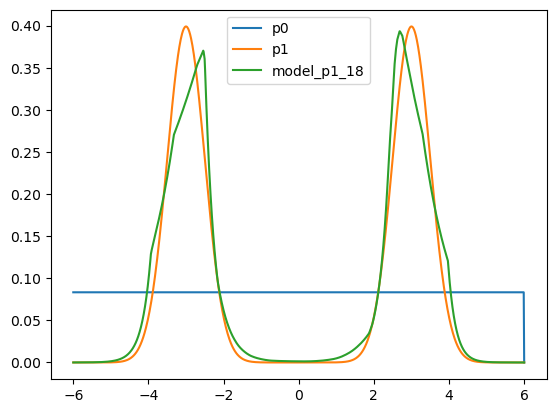

T:  17
Time:  18 iteration:  0 loss:  2.816032886505127 acc:  0.5 kl_div:  tensor(-9.0894, device='cuda:0') mse:  tensor(0.7875, device='cuda:0') js_div:  [0.00020058]
Time:  18 iteration:  100 loss:  2.238602638244629 acc:  0.46945 kl_div:  tensor(11985.4043, device='cuda:0') mse:  tensor(0.4281, device='cuda:0') js_div:  [0.00341103]
Time:  18 iteration:  200 loss:  2.173363208770752 acc:  0.46815 kl_div:  tensor(62.0469, device='cuda:0') mse:  tensor(0.0013, device='cuda:0') js_div:  [0.00260969]
Time:  18 iteration:  300 loss:  2.144270658493042 acc:  0.47085 kl_div:  tensor(38.0642, device='cuda:0') mse:  tensor(0.0008, device='cuda:0') js_div:  [0.0020233]
Time:  18 iteration:  400 loss:  2.118356227874756 acc:  0.47465 kl_div:  tensor(-8.1373, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00069688]
Time:  18 iteration:  500 loss:  2.0981669425964355 acc:  0.4708 kl_div:  tensor(11.1580, device='cuda:0') mse:  tensor(6.3585e-05, device='cuda:0') js_div:  [0.0

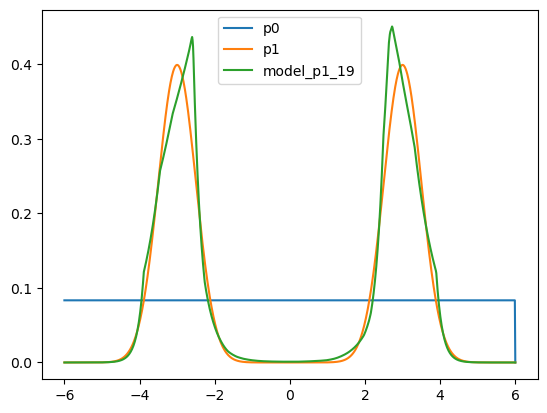

T:  18
Time:  19 iteration:  0 loss:  2.6641056537628174 acc:  0.5 kl_div:  tensor(-9.0857, device='cuda:0') mse:  tensor(0.7828, device='cuda:0') js_div:  [0.00028962]
Time:  19 iteration:  100 loss:  2.203411340713501 acc:  0.4952 kl_div:  tensor(11465.8105, device='cuda:0') mse:  tensor(0.4116, device='cuda:0') js_div:  [0.00226469]
Time:  19 iteration:  200 loss:  2.1604928970336914 acc:  0.49955 kl_div:  tensor(31.7126, device='cuda:0') mse:  tensor(0.0009, device='cuda:0') js_div:  [0.00190611]
Time:  19 iteration:  300 loss:  2.147562026977539 acc:  0.49835 kl_div:  tensor(18.3709, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00120534]
Time:  19 iteration:  400 loss:  2.120638847351074 acc:  0.50335 kl_div:  tensor(8.1027, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00044588]
Time:  19 iteration:  500 loss:  2.118565082550049 acc:  0.49685 kl_div:  tensor(5.1596, device='cuda:0') mse:  tensor(7.3632e-05, device='cuda:0') js_div:  [0.0

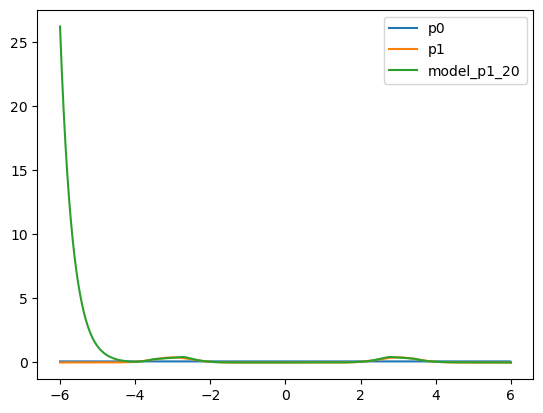

T:  19


In [12]:
model = train(u,30000,lr=1e-4,exponential=True,normalize_grad=True)